In [2]:
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
pd.set_option('display.max_columns', None)

In [242]:
es = pd.read_csv("C:\August2022\ES 12-22 Globex_2022_09_19.csv", index_col= 0, parse_dates=True )
mapping = {'AtBid': -1, 'AtAsk': 1, 'BelowBid': -2, 'AboveAsk': 2, 'BetweenBidAsk':0 }   # remap categorical ---->  ints 
es = es.replace({'AtAsk': mapping})
es.rename(columns={'1': 'Vol', 'AtAsk':'BidAsk', '3882.1':'Price' }, inplace=True)
del es['3881.75']  # deleting not needed columns
del es['3882']
es.index.name = 'DateTime' 
es['Date'] = es.index # make separate dateTime column
es.head()

Vol  BidAsk    Price                Date
DateTime                                                     
2022-09-19 00:00:02    1       1  3882.25 2022-09-19 00:00:02
2022-09-19 00:00:03    1      -1  3882.00 2022-09-19 00:00:03
2022-09-19 00:00:03    1      -1  3882.00 2022-09-19 00:00:03
2022-09-19 00:00:03    1      -1  3882.00 2022-09-19 00:00:03
2022-09-19 00:00:03    1      -1  3882.00 2022-09-19 00:00:03

In [243]:
es.shape # (1365444, 4)


(1365444, 4)

### Reducing the d set, by accounting for each second in 24 hrs, and then further reducing it by discarding NaN seconds without tick action (empty seconds).
Reduced to 6.32% of original size, some 94% reduction in size. 

In [225]:
def resample_df(df, col1, name1, col2, name2, col3, name3, on_col, on_name):
    df = pd.DataFrame({name1: col1, on_col: on_col})
    res_df = df.resample('1s', on= on_name).sum()
    return res_df

In [226]:
def resampling_sum(col1, name1, on_col, on_name):  
    '''make resampled df from columns on max; change to '1Min' if minutes needed'''
    df = pd.DataFrame({name1: col1, on_name: on_col})
    res_df = df.resample('1s', on= on_name).sum() #.fillna(0)
    return res_df

In [244]:
aa = resampling_sum(es['Vol'], 'Vol', es.Date, 'Date')
aa.shape  # (86394, 1)
aa.sample(4)

Vol
Date                    
2022-09-19 01:42:49    0
2022-09-19 11:04:36   67
2022-09-19 00:20:53    0
2022-09-19 10:43:27   15

In [245]:
def resampling_max(col1, name1, on_col, on_name):
    '''make resampled df from columns on max; change to '1Min' if minutes needed'''
    df = pd.DataFrame({name1: col1, on_name: on_col})
    res_df = df.resample('1s', on= on_name).max() #.fillna(0)
    return res_df

In [246]:
bb = resampling_max(es['BidAsk'], 'BidAsk',  es.Date, 'Date')
bb.shape  # (86394, 1)
bb.sample(4)

BidAsk
Date                       
2022-09-19 20:58:05     NaN
2022-09-19 00:42:32     NaN
2022-09-19 04:48:45     1.0
2022-09-19 08:57:20     NaN

In [247]:
cc = resampling_max(es['Price'], 'Price',  es.Date, 'Date')
cc.shape  # (86394, 1)
cc.sample(4)

Price
Date                        
2022-09-19 21:02:11  3924.00
2022-09-19 02:46:13      NaN
2022-09-19 10:00:01  3880.75
2022-09-19 07:34:43      NaN

In [248]:
def merge_resampled_DFs(d1, d2, d3):
    d = pd.DataFrame()
    d = pd.merge(d1, d2, on='Date')
    d = pd.merge(d, d3, on='Date')
    return d

In [249]:
fff = merge_resampled_DFs(aa, bb, cc)

In [250]:
fff.columns  #   (['Vol', 'BidAsk', 'Price'], dtype='object')
fff.index

DatetimeIndex(['2022-09-19 00:00:02', '2022-09-19 00:00:03',
               '2022-09-19 00:00:04', '2022-09-19 00:00:05',
               '2022-09-19 00:00:06', '2022-09-19 00:00:07',
               '2022-09-19 00:00:08', '2022-09-19 00:00:09',
               '2022-09-19 00:00:10', '2022-09-19 00:00:11',
               ...
               '2022-09-19 23:59:46', '2022-09-19 23:59:47',
               '2022-09-19 23:59:48', '2022-09-19 23:59:49',
               '2022-09-19 23:59:50', '2022-09-19 23:59:51',
               '2022-09-19 23:59:52', '2022-09-19 23:59:53',
               '2022-09-19 23:59:54', '2022-09-19 23:59:55'],
              dtype='datetime64[ns]', name='Date', length=86394, freq=None)

In [251]:
fff['Date'] = fff.index.copy()

In [258]:
fff.head(9)

Vol  BidAsk    Price                Date  \
Date                                                            
2022-09-19 00:00:02    1     1.0  3882.25 2022-09-19 00:00:02   
2022-09-19 00:00:03    6    -1.0  3882.00 2022-09-19 00:00:03   
2022-09-19 00:00:04    1     1.0  3882.00 2022-09-19 00:00:04   
2022-09-19 00:00:05    1     1.0  3882.25 2022-09-19 00:00:05   
2022-09-19 00:00:06    0     NaN      NaN 2022-09-19 00:00:06   
2022-09-19 00:00:07    0     NaN      NaN 2022-09-19 00:00:07   
2022-09-19 00:00:08    0     NaN      NaN 2022-09-19 00:00:08   
2022-09-19 00:00:09    0     NaN      NaN 2022-09-19 00:00:09   
2022-09-19 00:00:10    0     NaN      NaN 2022-09-19 00:00:10   

                     B_A_CumSumAvr1m  B_A_CumSumAvr5m  B_A_CumSumAvr10m  \
Date                                                                      
2022-09-19 00:00:02              NaN              NaN               NaN   
2022-09-19 00:00:03              NaN              NaN               NaN   
2022-09-19 00:00:04              NaN              NaN               NaN   
2022-09-19 00:00:05              NaN              NaN               NaN   
2022-09-19 00:00:06              NaN              NaN               NaN   
2022-09-19 00:00:07              NaN              NaN               NaN   
2022-09-19 00:00:08              NaN              NaN               NaN   
2022-09-19 00:00:09              NaN              NaN               NaN   
2022-09-19 00:00:10              NaN              NaN               NaN   

                     B_A_CumSumAvr30m  B_A_Kaya_1m  B_A_Kaya_3m  B_A_Kaya_10m  \
Date                                                                            
2022-09-19 00:00:02               NaN          NaN          NaN           NaN   
2022-09-19 00:00:03               NaN          NaN          NaN           NaN   
2022-09-19 00:00:04               NaN          NaN          NaN           NaN   
2022-09-19 00:00:05               NaN          NaN          NaN           NaN   
2022-09-19 00:00:06               NaN          NaN          NaN           NaN   
2022-09-19 00:00:07               NaN          NaN          NaN           NaN   
2022-09-19 00:00:08               NaN          NaN          NaN           NaN   
2022-09-19 00:00:09               NaN          NaN          NaN           NaN   
2022-09-19 00:00:10               NaN          NaN          NaN           NaN   

                     B_A_Kaya_30m  B_A_SumAvr10m  
Date                                              
2022-09-19 00:00:02           NaN            NaN  
2022-09-19 00:00:03           NaN            NaN  
2022-09-19 00:00:04           NaN            NaN  
2022-09-19 00:00:05           NaN            NaN  
2022-09-19 00:00:06           NaN            NaN  
2022-09-19 00:00:07           NaN            NaN  
2022-09-19 00:00:08           NaN            NaN  
2022-09-19 00:00:09           NaN            NaN  
2022-09-19 00:00:10           NaN            NaN

- cheking smaler column frame of specific feature of interest

In [238]:
# f4['Price'] = fff.Price
fff['B_A_CumSumAvr2K'] = fff['BidAsk'].rolling(2000).mean()  #  sum delta of Bid/Ask over 2K
fff['B_A_CumSumAvr4K'] = fff['BidAsk'].rolling(4000).mean() #  sum delta of Bid/Ask over 10K
fff['B_A_CumSumAvr10K'] = fff['BidAsk'].rolling(10000).mean() #  sum delta of Bid/Ask over 5K

In [254]:
fff['B_A_CumSumAvr1m'] = fff['BidAsk'].rolling(60).mean()   #  sum delta of Bid/Ask over 1min
fff['B_A_CumSumAvr5m'] = fff['BidAsk'].rolling(300).mean()  #  sum delta of Bid/Ask over 5min
fff['B_A_CumSumAvr10m'] = fff['BidAsk'].rolling(600).mean()    #  sum delta of Bid/Ask over 10min
fff['B_A_CumSumAvr30m'] = fff['BidAsk'].rolling(1800).mean()    #  sum delta of Bid/Ask over 10min

fff['B_A_Kaya_1m'] = fff['BidAsk'].rolling(60).mean()  *  60  / 100  #  prop Kaya 
fff['B_A_Kaya_3m'] = fff['BidAsk'].rolling(300).mean()  * 180 / 100   #  prop Kaya 
fff['B_A_Kaya_10m'] = fff['BidAsk'].rolling(600).mean()  * 600 / 100   #  prop Kaya 
fff['B_A_Kaya_30m'] = fff['BidAsk'].rolling(1800).mean()   * 1800 / 100   #  prop Kaya 

fff['B_A_SumAvr10m'] = fff['BidAsk'].rolling(600).sum()  #  sum delta of Bid/Ask over 10min
fff.shape  # (86394, 13)
# fff.columns


(86394, 13)

In [255]:
def resampling_sumMin(col1, name1, on_col, on_name):  
    '''make resampled df from columns on var; change to '1Min' if minutes needed'''
    df = pd.DataFrame({name1: col1, on_name: on_col})
    res_df = df.resample('1Min', on= on_name).var() #.fillna(0)
    return res_df

In [256]:
fff.columns
fff.shape # (86394, 12)
# fff = fff.dropna()
fff.shape # (86394, 12)

(86394, 13)

In [ ]:
fff.sample(20)

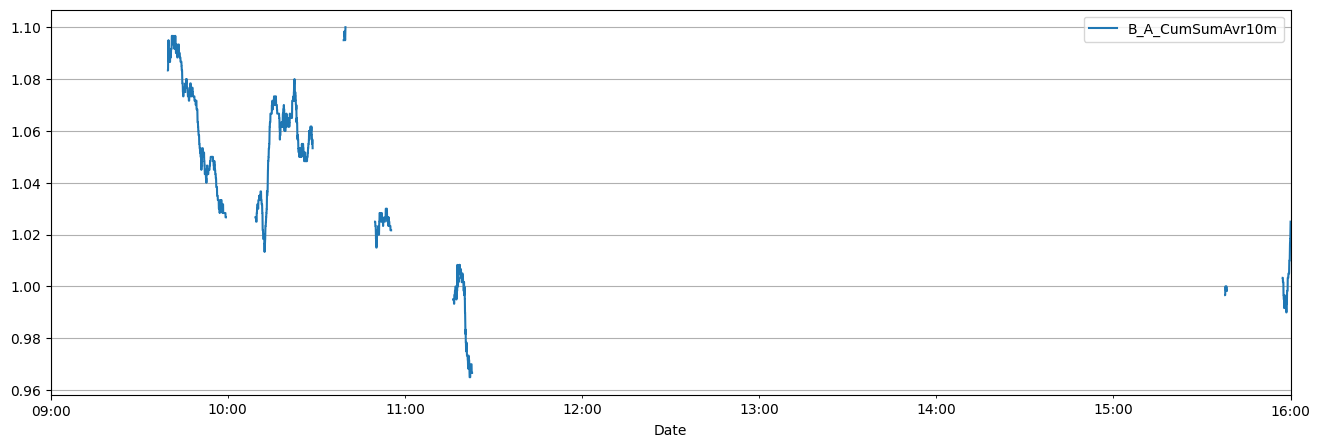

In [186]:
fff['2022-09-19 09:00:00': '2022-09-19 16:00:00'].plot(y = 'B_A_CumSumAvr10m', figsize=(16,5))  # var min B_A_CumSumAvr
plt.grid()   

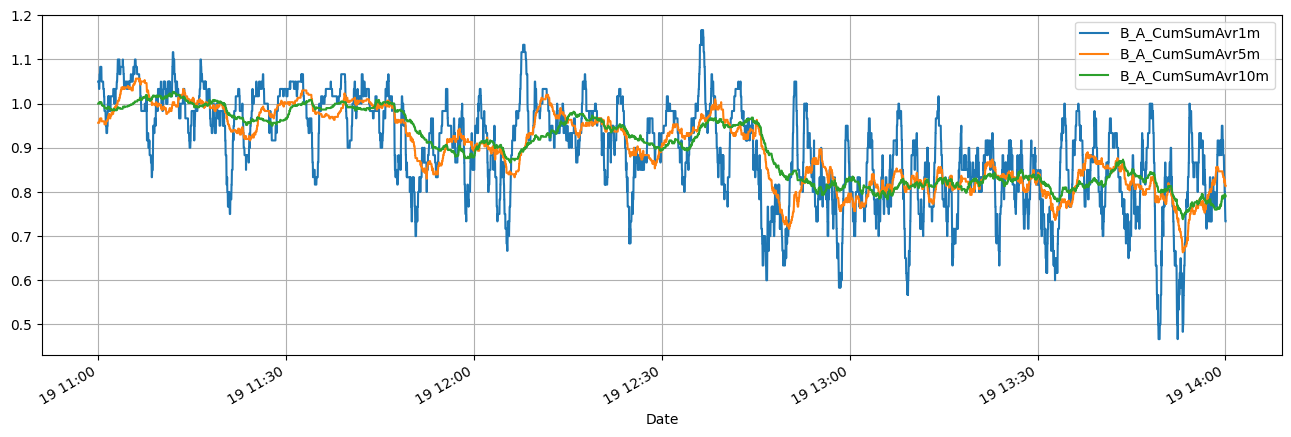

In [39]:
fff['2022-09-19 11:00:00': '2022-09-19 14:00:00'].plot(y = ['B_A_CumSumAvr1m', 'B_A_CumSumAvr5m','B_A_CumSumAvr10m'] , figsize=(16,5))  # var min B_A_CumSumAvr
plt.grid()   

### Make Target y column based on Price projected 5 , 10, 15, 30 min

In [41]:
fff['PTarget5'] = fff.Price.shift((60*5))
fff['PTarget10'] = fff.Price.shift((60*10))
fff['PTarget15'] = fff.Price.shift((60*15))
fff['PTarget30'] = fff.Price.shift((60*30))
fff['PTarget60'] = fff.Price.shift((60*60))
fff.columns

Index(['Vol', 'BidAsk', 'Price', 'PTarget5', 'PTarget10', 'PTarget15',
       'PTarget30', 'PTarget60', 'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'],
      dtype='object')

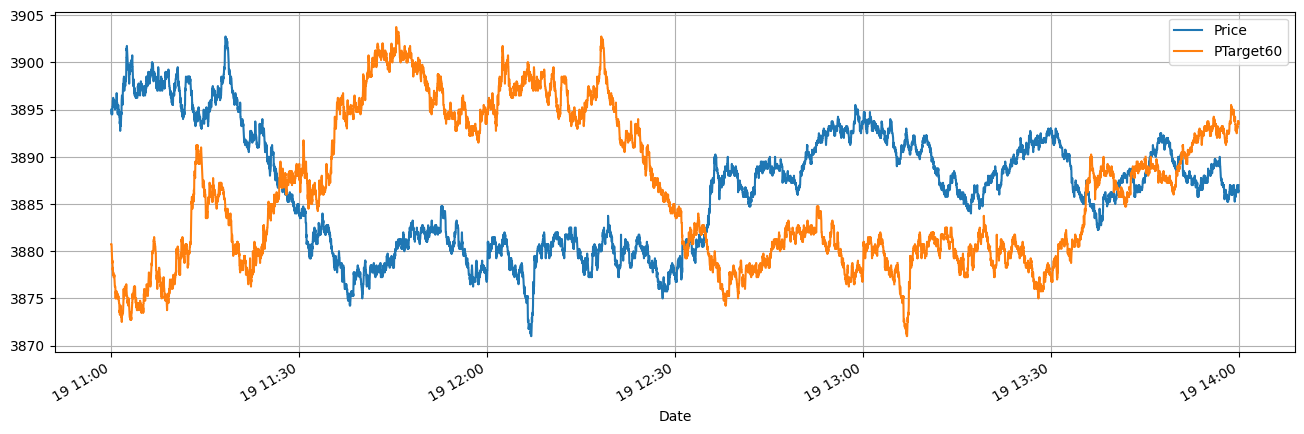

In [40]:
fff['2022-09-19 11:00:00': '2022-09-19 14:00:00'].plot(y = ['Price', 'PTarget60'] , figsize=(16,5))  # PriceTarget moved 60 min forward
plt.grid()

In [17]:
'''timestamp_s = total_time.map(pd.Timestamp.timestamp)
fff['10Min_sin'] = np.sin(fff.Date * (2 * np.pi / fff.Date.min))  # test
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df['Second sin'] = np.sin(timestamp_s * (2 * np.pi / second))
df['Second cos'] = np.cos(timestamp_s * (2 * np.pi / second))'''

"timestamp_s = total_time.map(pd.Timestamp.timestamp)\nfff['10Min_sin'] = np.sin(fff.Date * (2 * np.pi / fff.Date.min))  # test\ndf['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))\ndf['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))\ndf['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))\ndf['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))\ndf['Second sin'] = np.sin(timestamp_s * (2 * np.pi / second))\ndf['Second cos'] = np.cos(timestamp_s * (2 * np.pi / second))"

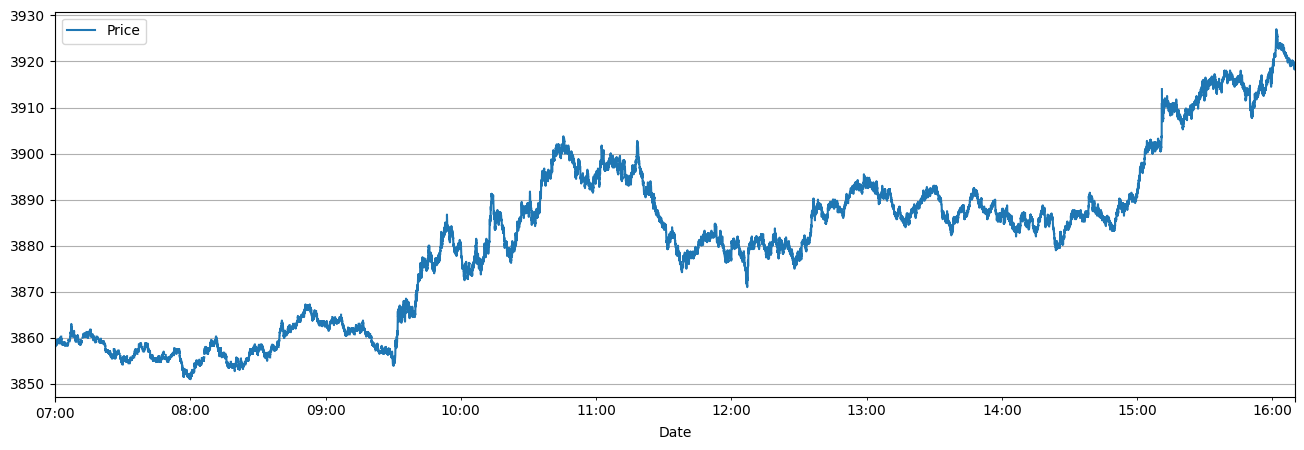

In [18]:
fff['2022-09-19 07:00:00': '2022-09-19 16:10:00'].plot( y='Price', figsize=(16,5)) 
plt.grid()

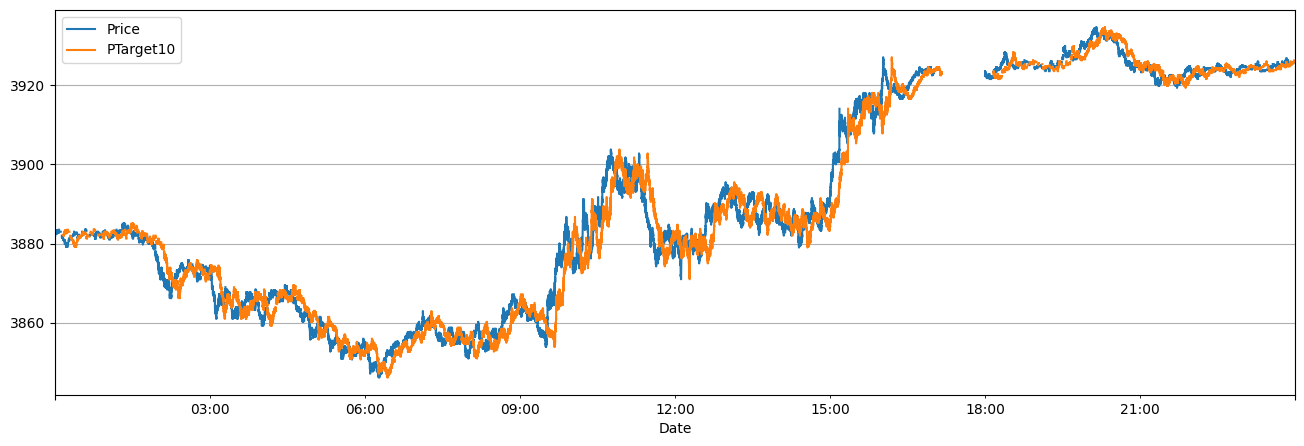

In [19]:
fff.plot( y=['Price','PTarget10'], figsize=(16,5)) # 10 min into the future shifted  Price
plt.grid()

### Derived features

In [30]:
fff.shape  # (58799, 30)

(49429, 8)

In [29]:
#  delete rows without tick transaction (BidAsk or Price)
fff =  fff.dropna(axis=0, thresh= fff['BidAsk'], subset=None, inplace=False)
fff.shape  # (40912, 9)   btw induced further reduction of unneeded rows by ~ 30%

(49429, 8)

In [31]:
fff['BA_10sum'] = fff['BidAsk'].rolling((60*10)).sum()  # 10 min BidAsk sum
fff['BA_10mean'] = fff['BidAsk'].rolling((60*10)).mean() # 10 min BidAsk mean
fff['BA_St_2m'] = (fff['BidAsk'].rolling((60*2)).sum() - fff['BidAsk'].rolling((60*5)).sum())  / (fff['BidAsk'].rolling((60*2)).min() - fff['BidAsk'].rolling((60*5)).max()) * 0.1 # Stochastic BidAsk 
fff['BA_St_5m'] = (fff['BidAsk'].rolling((60*5)).sum() - fff['BidAsk'].rolling((60*10)).sum()) / (fff['BidAsk'].rolling((60*10)).min()- fff['BidAsk'].rolling((60*10)).max()) * 0.1 # Stochastic BidAsk

fff['Prc_St_1m'] = (fff['Price'].rolling(60).mean()  - fff['Price'].rolling(60*2).min())  / (fff['Price'].rolling(60).max() - fff['Price'].rolling(60).min())  # Stochastic
fff['Prc_St_5m'] = (fff['Price'].rolling(60*5).mean()  - fff['Price'].rolling(60*7).min())  / (fff['Price'].rolling(60*5).max() - fff['Price'].rolling(60*5).min())  # Stochastic


fff['STD5m'] = fff['Price'].rolling(300).std()
fff['MA10m'] = fff['Price'].rolling(600).mean() 
fff['MA21m'] = fff['Price'].rolling(1260).mean() 
fff['MA100'] = fff['Price'].rolling(6000).mean() 

fff['B_A_CumSum'] = fff['BidAsk'].cumsum()  # cumulative sum delta of Bid/Ask

fff['5_val'] = fff.rolling('5T').Vol.sum() # 

fff['BA_Vol_Avg5'] = fff['BidAsk'].rolling(300).var() *  fff['BidAsk'].rolling(300).sum()  * fff['Vol'].rolling(300).mean() 
fff['BA_BA_Avg30'] = fff['BidAsk'].rolling(1800).var() *  fff['BidAsk'].rolling(1800).sum()  * fff['BidAsk'].rolling(1800).mean() 

fff['Var_Vol_30m'] = fff['Price'].rolling(1800).var() / fff['Price'].rolling(1800).mean()
fff['Var_MinMax_MA10m'] = fff['Price'].rolling(600).var()   *  fff['Price'].rolling(600).min()  / fff['Price'].rolling(600).max() 
fff['Var_ver'] = fff['Price'].rolling(2000).var() / fff['Price'].rolling(1000).var() * 100 # Price variance difference over 2K / 1K 

fff['B_A_CumSumAvr1m'] = fff['BidAsk'].rolling(60).mean() #  sum delta of Bid/Ask over 1 min
fff['B_A_CumSumAvr5m'] = fff['BidAsk'].rolling(300).mean() #  sum delta of Bid/Ask over 5 min
fff['B_A_CumSumAvr10m'] = fff['BidAsk'].rolling(600).mean() #  sum delta of Bid/Ask over 10 min

In [32]:
fff.sample(3)

Vol  BidAsk    Price  PTarget5  PTarget10  PTarget15  \
Date                                                                        
2022-09-19 05:27:04   15     1.0  3856.50   3855.50     3857.5     3859.0   
2022-09-19 13:58:30  162     1.0  3886.25   3886.50     3892.0     3886.0   
2022-09-19 14:31:10  106     1.0  3886.00   3882.75     3885.0     3884.5   

                     PTarget30  PTarget60  BA_10sum  BA_10mean  BA_St_2m  \
Date                                                                       
2022-09-19 05:27:04        NaN    3869.25     269.0   0.448333  3.166667   
2022-09-19 13:58:30    3892.00    3892.75     456.0   0.760000  5.366667   
2022-09-19 14:31:10    3885.25    3892.00     536.0   0.893333  5.133333   

                     BA_St_5m  Prc_St_1m  Prc_St_5m     STD5m        MA10m  \
Date                                                                         
2022-09-19 05:27:04  3.566667   1.066667   0.495490  0.937561  3856.687083   
2022-09-19 13:58:30  6.700000   0.397917   0.497544  1.247099  3888.457917   
2022-09-19 14:31:10  9.200000   0.835000   0.627654  1.693680  3883.009583   

                           MA21m        MA100  B_A_CumSum    5_val  \
Date                                                                 
2022-09-19 05:27:04  3858.023810  3864.899500      3422.0   1322.0   
2022-09-19 13:58:30  3887.788690  3887.049542     22346.0  15093.0   
2022-09-19 14:31:10  3884.239484  3887.777125     23956.0  16577.0   

                     BA_Vol_Avg5  BA_BA_Avg30  Var_Vol_30m  Var_MinMax_MA10m  \
Date                                                                           
2022-09-19 05:27:04  1468.914574   277.866924     0.004189          4.918400   
2022-09-19 13:58:30  4511.630142   461.767261     0.001574          2.656108   
2022-09-19 14:31:10  3971.839614   411.966338     0.001100          5.018044   

                        Var_ver  B_A_CumSumAvr1m  B_A_CumSumAvr5m  \
Date                                                                
2022-09-19 05:27:04  473.874789         0.683333         0.540000   
2022-09-19 13:58:30  209.462465         0.766667         0.850000   
2022-09-19 14:31:10   84.190025         0.900000         0.866667   

                     B_A_CumSumAvr10m  
Date                                   
2022-09-19 05:27:04          0.448333  
2022-09-19 13:58:30          0.760000  
2022-09-19 14:31:10          0.893333

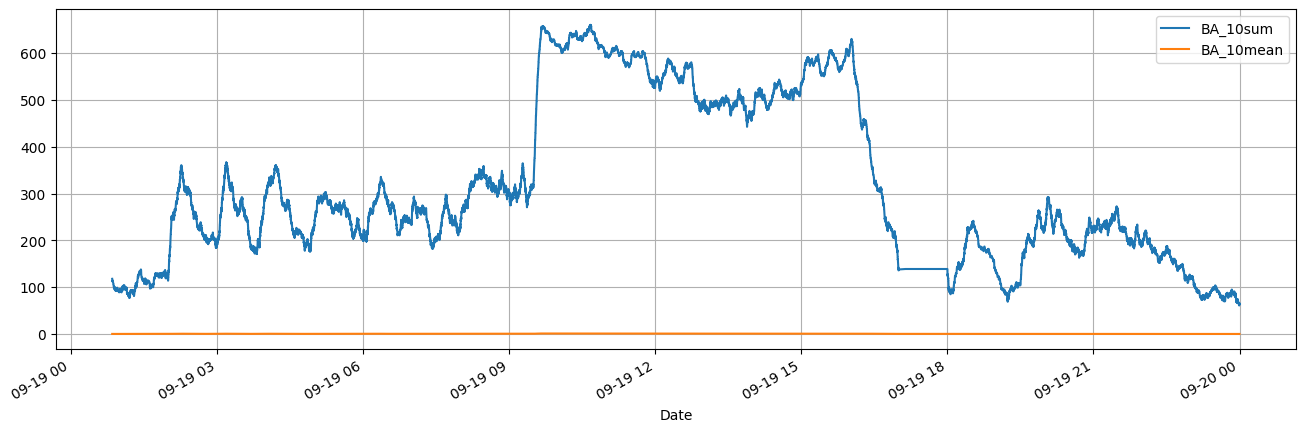

In [33]:
fff.plot( y=['BA_10sum','BA_10mean'], figsize=(16,5)) # 10 min into the future shifted  Price
plt.grid()

In [26]:
fff.columns

Index(['Vol', 'BidAsk', 'Price', 'PTarget5', 'PTarget10', 'PTarget15',
       'PTarget30', 'PTarget60', 'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'],
      dtype='object')

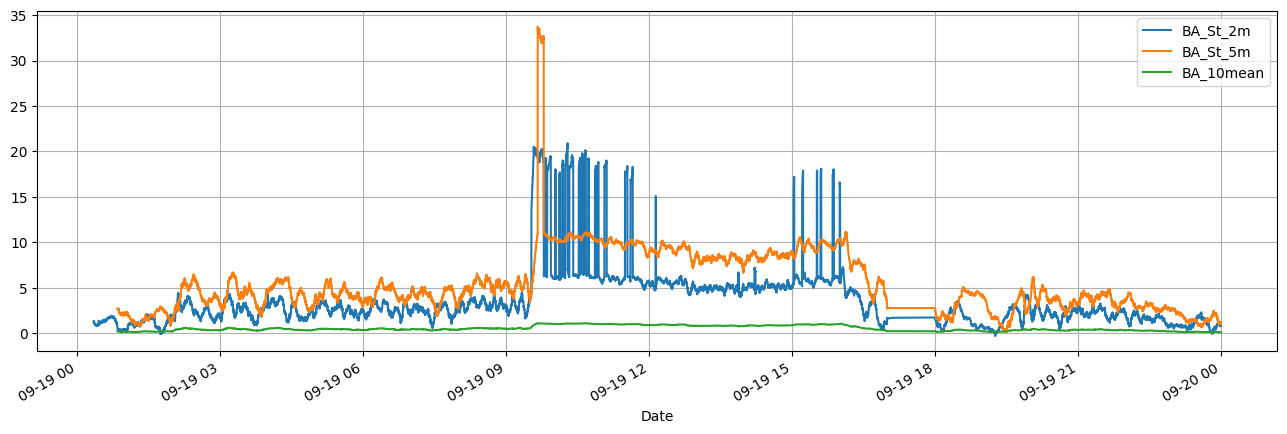

In [50]:
fff.plot( y=['BA_St_2m','BA_St_5m','BA_10mean'], figsize=(16,5)) # 10 min into the future shifted  Price
plt.grid()

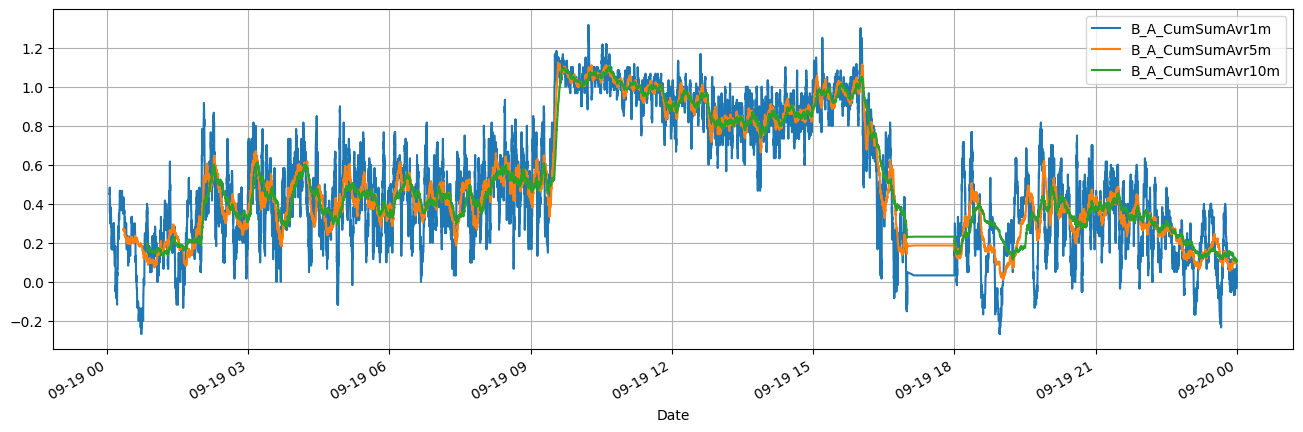

In [51]:
fff.plot( y=['B_A_CumSumAvr1m','B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'], figsize=(16,5)) # 10 min into the future shifted  Price
plt.grid()

In [29]:
fff.sample(9)

Vol  BidAsk    Price  PTarget5  PTarget10  PTarget15  \
Date                                                                        
2022-09-19 14:36:28   15     1.0  3886.25   3887.75    3881.25        NaN   
2022-09-19 12:58:09    2     1.0  3892.50   3891.75    3887.50    3888.75   
2022-09-19 13:35:35    3     1.0  3886.00   3891.75    3890.25    3887.50   
2022-09-19 14:50:37  121     1.0  3885.75   3885.25    3887.50    3885.50   
2022-09-19 11:39:44   17     1.0  3877.75   3882.25    3885.00    3891.00   
2022-09-19 11:09:13   22     1.0  3897.75   3896.75    3894.50    3895.00   
2022-09-19 04:07:35    1    -1.0  3865.25   3860.50    3862.25        NaN   
2022-09-19 06:50:31    7     1.0  3856.50       NaN        NaN    3854.50   
2022-09-19 12:11:20   29     1.0  3881.25   3874.75    3881.00    3880.00   

                     PTarget30  PTarget60  BA_10sum  BA_10mean  BA_St_2m  \
Date                                                                       
2022-09-19 14:36:28    3883.00    3885.00     516.0   0.860000  5.300000   
2022-09-19 12:58:09    3876.75    3877.00     486.0   0.810000  4.866667   
2022-09-19 13:35:35    3889.50    3884.75     485.0   0.808333  4.300000   
2022-09-19 14:50:37    3884.75    3889.75     508.0   0.846667  4.833333   
2022-09-19 11:39:44    3895.75    3895.25     597.0   0.995000  6.133333   
2022-09-19 11:09:13    3894.75    3875.75     610.0   1.016667  6.233333   
2022-09-19 04:07:35        NaN    3861.50     328.0   0.546667  3.633333   
2022-09-19 06:50:31    3849.25        NaN     246.0   0.410000  2.900000   
2022-09-19 12:11:20    3878.25    3894.25     555.0   0.925000  6.066667   

                      BA_St_5m  Prc_St_1m  Prc_St_5m     STD5m        MA10m  \
Date                                                                          
2022-09-19 14:36:28   8.666667   0.480556   1.281000  0.580510  3885.119167   
2022-09-19 12:58:09   8.333333   0.583333   1.125556  0.636309  3890.713750   
2022-09-19 13:35:35   8.333333   0.513333   0.469688  2.459315  3890.167083   
2022-09-19 14:50:37   8.633333   0.498485   0.459744  0.888523  3885.958333   
2022-09-19 11:39:44   9.766667   1.672917   0.439375  1.865846  3880.038750   
2022-09-19 11:09:13  10.333333   0.639583   0.493810  0.758694  3897.277083   
2022-09-19 04:07:35   5.266667   0.708974   0.440000  1.766186  3863.125417   
2022-09-19 06:50:31   3.733333   1.716667   0.507895  1.463195  3854.518750   
2022-09-19 12:11:20   8.400000   1.438889   0.701364  3.288590  3878.772083   

                           MA21m        MA100  B_A_CumSum    5_val  \
Date                                                                 
2022-09-19 14:36:28  3884.608532  3887.695208     24216.0  15470.0   
2022-09-19 12:58:09  3889.294246  3883.482125     19551.0  11271.0   
2022-09-19 13:35:35  3888.581349  3885.279875     21291.0  12807.0   
2022-09-19 14:50:37  3886.432341  3886.885375     24912.0  17487.0   
2022-09-19 11:39:44  3885.657937  3889.206542     15389.0  28851.0   
2022-09-19 11:09:13  3896.411111  3884.308000     13587.0  16066.0   
2022-09-19 04:07:35  3864.218452  3871.292833      2373.0   2376.0   
2022-09-19 06:50:31  3851.820437  3858.437708      4452.0   2300.0   
2022-09-19 12:11:20  3879.618452  3888.736375     17116.0  28090.0   

                     BA_Vol_Avg5  BA_BA_Avg30  Var_Vol_30m  Var_MinMax_MA10m  \
Date                                                                           
2022-09-19 14:36:28  4514.601763   408.877893     0.001158          4.152832   
2022-09-19 12:58:09  4747.186919   436.902241     0.006496          5.086695   
2022-09-19 13:35:35  4490.310312   464.737566     0.001522          5.287838   
2022-09-19 14:50:37  5442.347031   416.401032     0.001622          2.380545   
2022-09-19 11:39:44  1559.614578   240.575332     0.013867          7.950871   
2022-09-19 11:09:13  2274.180602   224.081268     0.001827          2.994533   
2022-09-19 04:07:35  1758.100706   305.439485     0.001

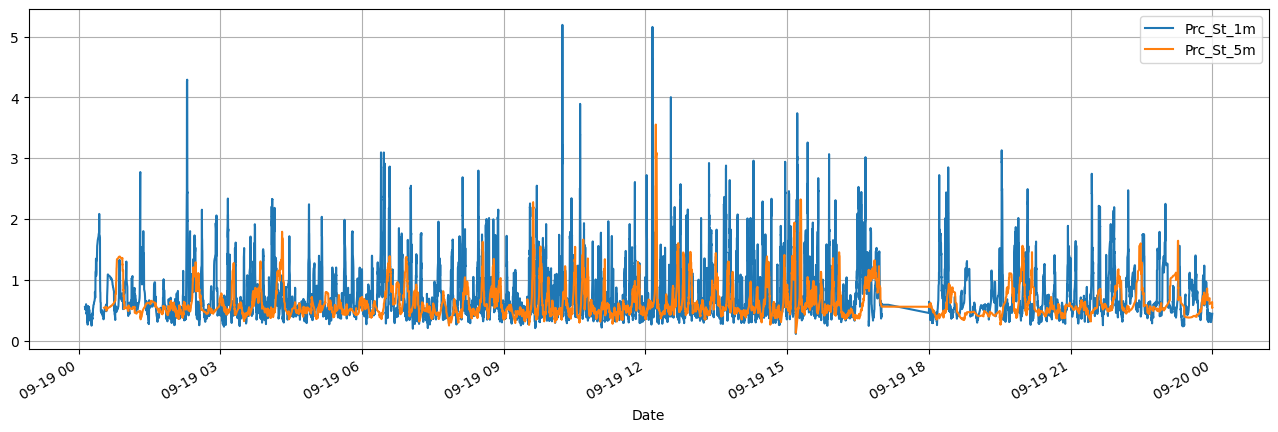

In [52]:
fff.plot( y=['Prc_St_1m', 'Prc_St_5m'], figsize=(16,5)) # 
plt.grid()

In [31]:
fff.columns

Index(['Vol', 'BidAsk', 'Price', 'PTarget5', 'PTarget10', 'PTarget15',
       'PTarget30', 'PTarget60', 'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'],
      dtype='object')

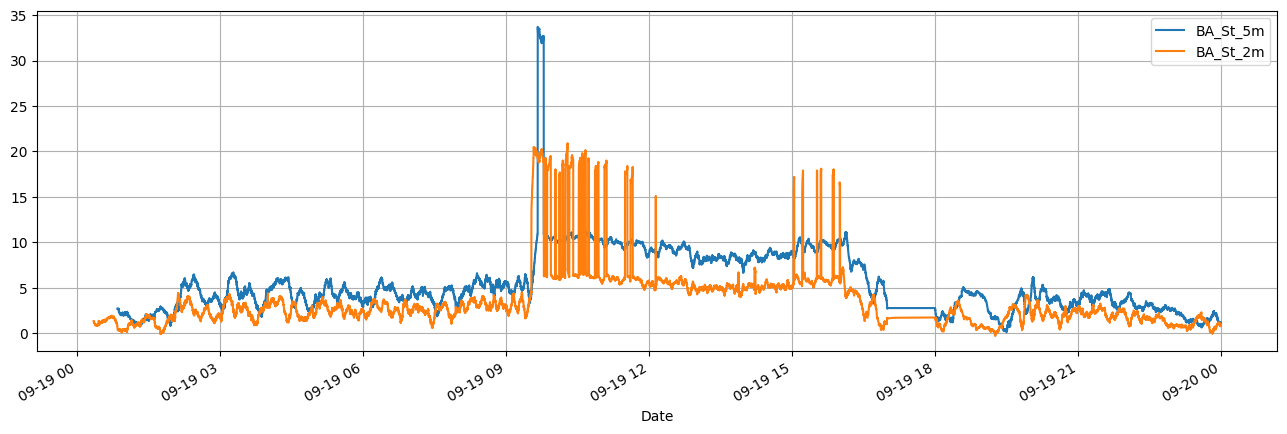

In [53]:
fff.plot( y=[ 'BA_St_5m','BA_St_2m'], figsize=(16,5)) # 
plt.grid()

In [38]:
import os
# from library.sb_utils import save_file
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [40]:
# Create a new dataframe, `es__scale` from `fff` 
es__scale = fff.copy()
# Save the labels (using the index attribute of `es1`) into the variable 'es_index'
es_index = fff.index
# # Save the column names (using the `columns` attribute) of `es1` into the variable 'es_columns'
es_columns = fff.columns

In [ ]:
es__scale

In [45]:
es__scale = es__scale.fillna(0)
es__scale = es__scale[np.isfinite(es__scale).all(1)]  # to get rid of Infinite values 

In [ ]:
es__scale

In [46]:
scaler1 = StandardScaler()
es__scaled = scaler1.fit_transform(es__scale)

In [47]:
es_scaled_df = pd.DataFrame(es__scaled, columns= es_columns)
es_scaled_df.sample(9)

Vol    BidAsk     Price  PTarget5  PTarget10  PTarget15  \
8301   0.345137  0.362498 -1.335005 -1.984063   0.494898   0.504282   
13037 -0.517130  0.362498 -1.208778  0.487700  -1.965347   0.504597   
36436 -0.200601  0.362498  0.838897  0.508370   0.511471   0.521301   
36431  0.148671  0.362498  0.838897  0.508370   0.511471   0.521301   
9419  -0.517130 -2.267260 -1.447206 -1.984063   0.490277   0.501603   
21739 -0.255175  0.362498  1.189527  0.515901   0.517367   0.520986   
10780 -0.004135  0.362498 -1.433181 -1.984063   0.490436  -1.927630   
26118 -0.353408  0.362498  0.039462  0.502442   0.509240   0.518937   
21659  0.759899  0.362498  1.203552  0.515421   0.518004   0.522719   

       PTarget30  PTarget60  BA_10sum  BA_10mean  BA_St_2m  BA_St_5m  \
8301   -1.841302  -1.723132 -0.918208  -0.918208 -0.768379 -0.402025   
13037   0.528880   0.568251 -1.117142  -1.117142 -0.831829 -0.659570   
36436   0.547009   0.585329  0.649153   0.649153 -0.062503  0.387779   
36431   0.546548   0.586220  0.661210   0.661210 -0.062503  0.404949   
9419   -1.841302   0.567954 -1.273878  -1.273878 -0.744585 -0.968623   
21739   0.546548   0.579389  1.167588   1.167588  0.191295  0.834190   
10780   0.524118   0.566172 -1.171397  -1.171397 -0.601824 -0.788342   
26118   0.542707   0.590378  0.703408   0.703408 -0.006985  0.447873   
21659   0.546548   0.580726  1.191701   1.191701  0.230950  0.817020   

       Prc_St_1m  Prc_St_5m     STD5m     MA10m     MA21m     MA100  \
8301   -0.446222  -0.085362  0.148070  0.078125  0.150564  0.406642   
13037  -0.070607  -1.077949 -1.136499  0.073838  0.146231  0.399465   
36436   0.110955   0.037628 -0.392457  0.144485  0.192248  0.422144   
36431  -0.046454  -0.011418 -0.470420  0.144332  0.192229  0.422139   
9419   -0.453717  -0.507716 -0.815685  0.066589  0.141736  0.404042   
21739  -0.785667  -0.355108 -0.758815  0.165892  0.201430  0.414738   
10780  -0.847239  -0.056085 -0.691309  0.065572  0.137410  0.401632   
26118   2.265536  -0.572777  0.065557  0.124893  0.180672  0.423833   
21659  -0.750660   2.498501 -0.702161  0.164242  0.199982  0.414373   

       B_A_CumSum     5_val  BA_Vol_Avg5  BA_BA_Avg30  Var_Vol_30m  \
8301    -1.003609 -0.969297    -0.886322    -0.521917     0.060397   
13037   -0.787234 -0.982896    -0.876025    -0.539649    -0.664103   
36436    1.425724  0.296936     0.798902     0.944521    -0.621584   
36431    1.425176  0.287032     0.784472     0.944521    -0.627007   
9419    -0.953077 -0.938484    -0.740852    -0.181278    -0.471964   
21739   -0.012606  0.891261    -0.416016    -0.900524     2.845351   
10780   -0.887968 -1.001053    -0.764832    -0.271004    -0.528448   
26118    0.455438  0.372868     0.804937     0.027053    -0.607022   
21659   -0.021375  1.270605    -0.267825    -0.873048     2.551876   

       Var_MinMax_MA10m   Var_ver  B_A_CumSumAvr1m  B_A_CumSumAvr5m  \
8301          -0.601890  0.859976        -1.384730        -1.365243   
13037         -0.801173  0.455189        -0.760602        -1.401422   
36436         -0.460382 -0.593496         0.941564         0.660746   
36431         -0.473403 -0.584435         0.941564         0.660746   
9419          -0.916999  1.171617        -1.895380        -1.280827   
21739          0.199550 -0.267979         0.941564         1.070768   
10780         -0.279628 -0.676875        -2.235814        -1.329065   
26118         -0.134204 -0.186950         0.771348         0.684865   
21659          0.544978 -0.354339         0.941564         1.143125   

       B_A_CumSumAvr10m  
8301          -0.918208  
13037         -1.117142  
36436          0.649153  
36431          0.661210  
9419          -1.273878  
21739          1.167588  
10780         -1.171397  
26118          0.703408  
21659          1.191701

In [48]:
es_scaled_df.mean()

Vol                 1.111526e-17
BidAsk              6.113391e-17
Price               2.712122e-15
PTarget5           -8.892205e-17
PTarget10           2.223051e-17
PTarget15          -2.223051e-17
PTarget30          -6.669154e-17
PTarget60          -5.557628e-17
BA_10sum            1.111526e-16
BA_10mean          -2.223051e-17
BA_St_2m            2.223051e-17
BA_St_5m            1.556136e-16
Prc_St_1m          -1.889594e-16
Prc_St_5m          -2.056322e-16
STD5m               2.625979e-16
MA10m               5.891086e-16
MA21m               1.834017e-16
MA100              -1.556136e-16
B_A_CumSum          1.778441e-16
5_val              -1.111526e-16
BA_Vol_Avg5        -2.223051e-17
BA_BA_Avg30         1.111526e-16
Var_Vol_30m         8.892205e-17
Var_MinMax_MA10m   -5.001865e-17
Var_ver            -2.612085e-16
B_A_CumSumAvr1m     0.000000e+00
B_A_CumSumAvr5m    -4.890713e-16
B_A_CumSumAvr10m   -2.223051e-17
dtype: float64

In [49]:
es_scaled_df.std()

Vol                 1.000012
BidAsk              1.000012
Price               1.000012
PTarget5            1.000012
PTarget10           1.000012
PTarget15           1.000012
PTarget30           1.000012
PTarget60           1.000012
BA_10sum            1.000012
BA_10mean           1.000012
BA_St_2m            1.000012
BA_St_5m            1.000012
Prc_St_1m           1.000012
Prc_St_5m           1.000012
STD5m               1.000012
MA10m               1.000012
MA21m               1.000012
MA100               1.000012
B_A_CumSum          1.000012
5_val               1.000012
BA_Vol_Avg5         1.000012
BA_BA_Avg30         1.000012
Var_Vol_30m         1.000012
Var_MinMax_MA10m    1.000012
Var_ver             1.000012
B_A_CumSumAvr1m     1.000012
B_A_CumSumAvr5m     1.000012
B_A_CumSumAvr10m    1.000012
dtype: float64

In [50]:
es_pca = PCA().fit(es_scaled_df)

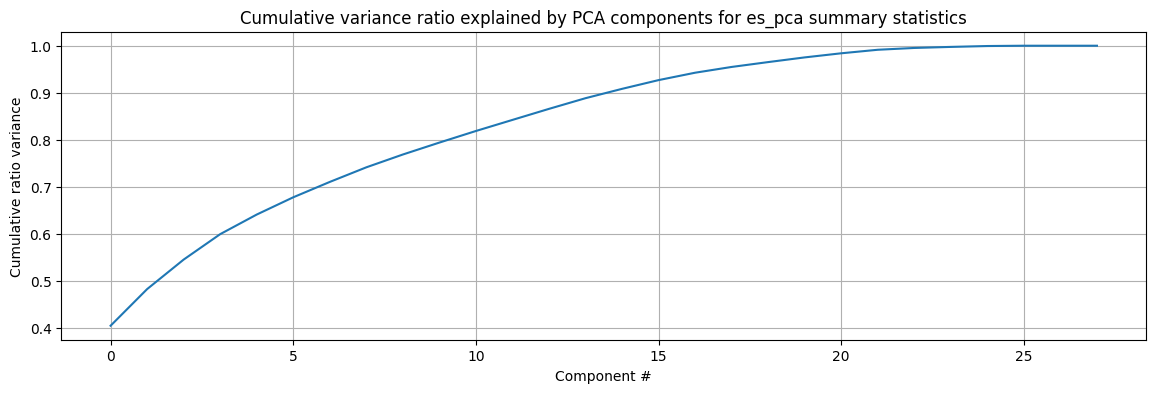

In [51]:
plt.subplots(figsize=(14, 4))
plt.plot(es_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for es_pca summary statistics')
plt.grid()

In [52]:
es_pca_x = es_pca.transform(es__scaled)

c:\Users\tonya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [53]:
es_pca_x.shape  # (40912, 28)

(40912, 28)

In [54]:
es_pca_x

array([[-9.90391783e+00,  5.72803924e+00,  6.33964576e+00, ...,
        -2.31309820e-01, -2.44249065e-15, -2.22044605e-16],
       [-1.01912960e+01,  5.59306166e+00,  6.25100565e+00, ...,
        -2.35069438e-01, -1.77635684e-15, -2.22044605e-16],
       [-9.90659746e+00,  5.72689534e+00,  6.33392729e+00, ...,
        -2.31939742e-01, -2.44249065e-15, -2.22044605e-16],
       ...,
       [ 9.05577198e-01, -2.51798476e+00,  1.98809621e+00, ...,
         1.09812705e-01, -1.47676950e-15, -2.65300932e-17],
       [ 1.21826168e+00, -2.35737987e+00,  2.09903140e+00, ...,
         1.14467301e-01, -2.11514774e-15, -1.23674608e-16],
       [ 8.50463543e-01, -2.54012515e+00,  1.99003946e+00, ...,
         1.11616778e-01, -1.43145950e-15, -1.76830253e-17]])

In [ ]:
x = es_pca_x[:, 0]
y = es_pca_x[:, 1]
esx = es_index
pc_var = 100 * es_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(50,50))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'ES summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(esx, x, y):
    plt.annotate(s, (x, y))

Text(0.5, 1.0, 'Correlations in ES data')

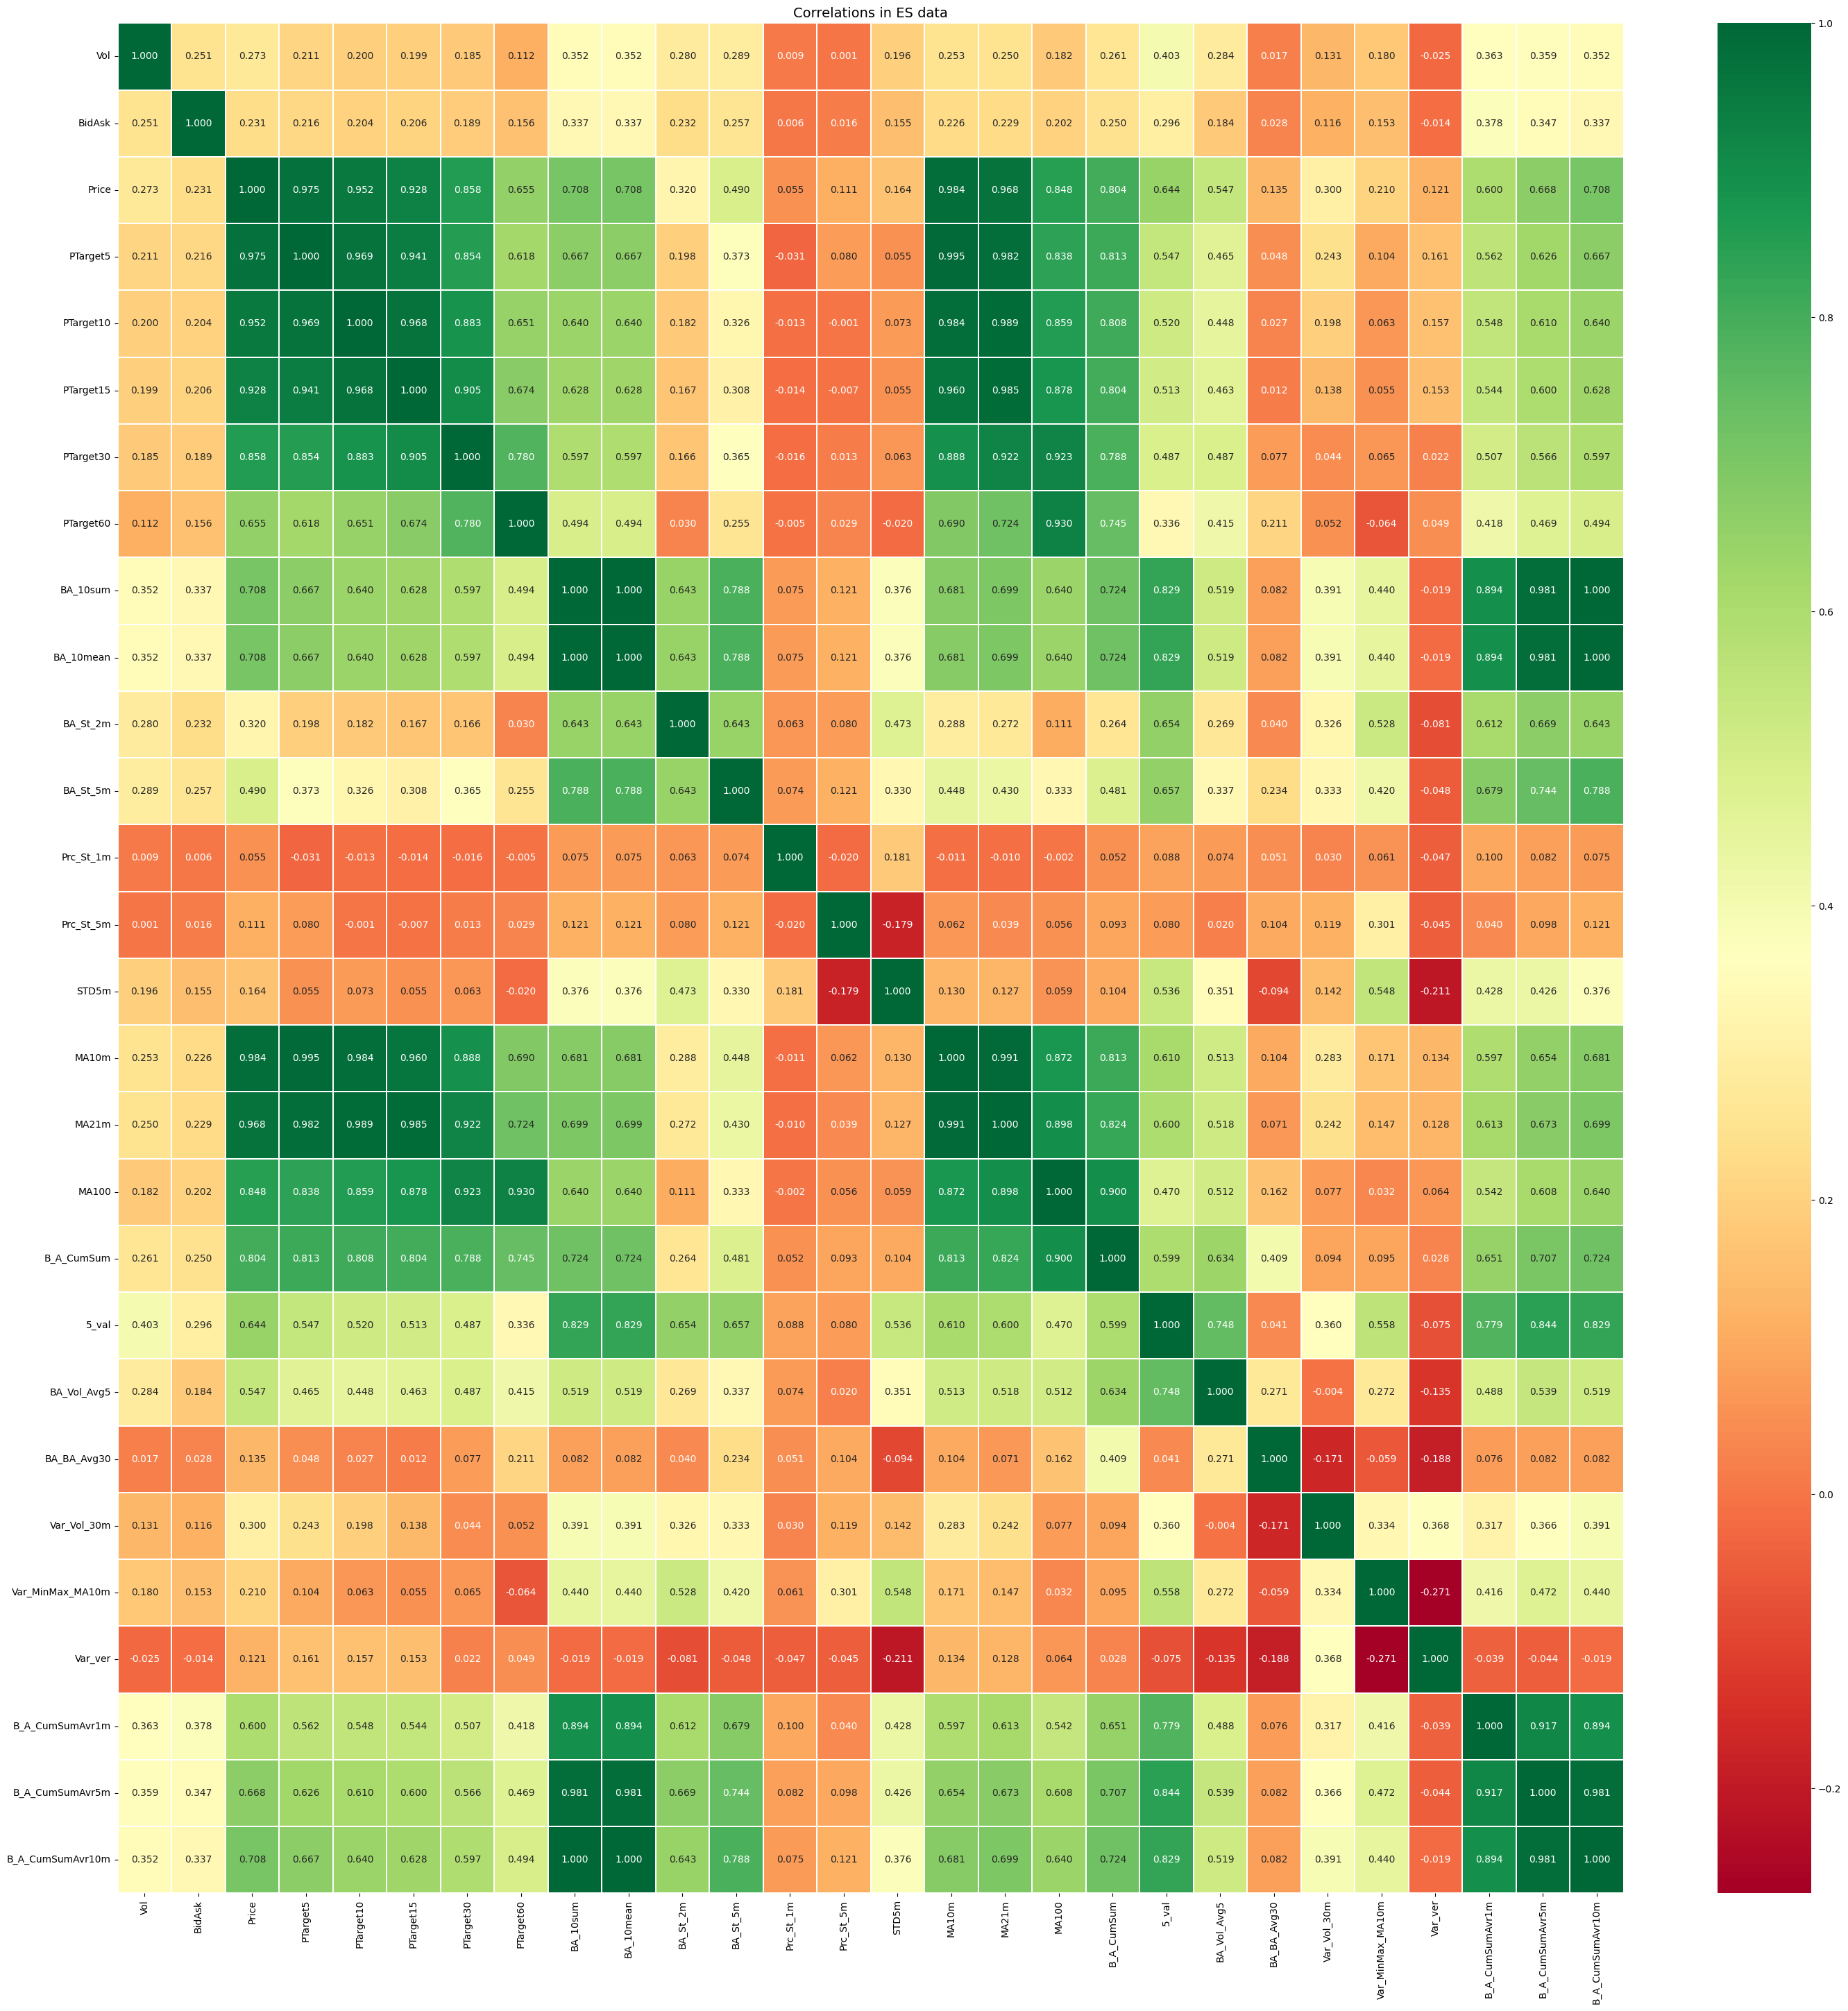

In [62]:
# seaborn heatmap of correlations in es data
plt.subplots(figsize=(35,35))
# Using numpy ‘.tril()’ method to take the upper correlation matrix and mask attribute: to create an upper triangle matrix.
#matrix = np.tril(es1.corr())
#sns.heatmap(ski_data.corr(), linewidths=.1, annot=True, cmap='coolwarm', center=0, mask=matrix);
sns.heatmap(fff.corr(), linewidths=.1, annot=True, cmap='RdYlGn', fmt='.3f')
plt.title('Correlations in ES data', fontsize=14)

In [74]:
fff.columns
fff.shape

(40912, 28)

In [64]:
ar = ['Price',  'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m']

Text(0.5, 1.0, 'Correlations between Price vs. features ')

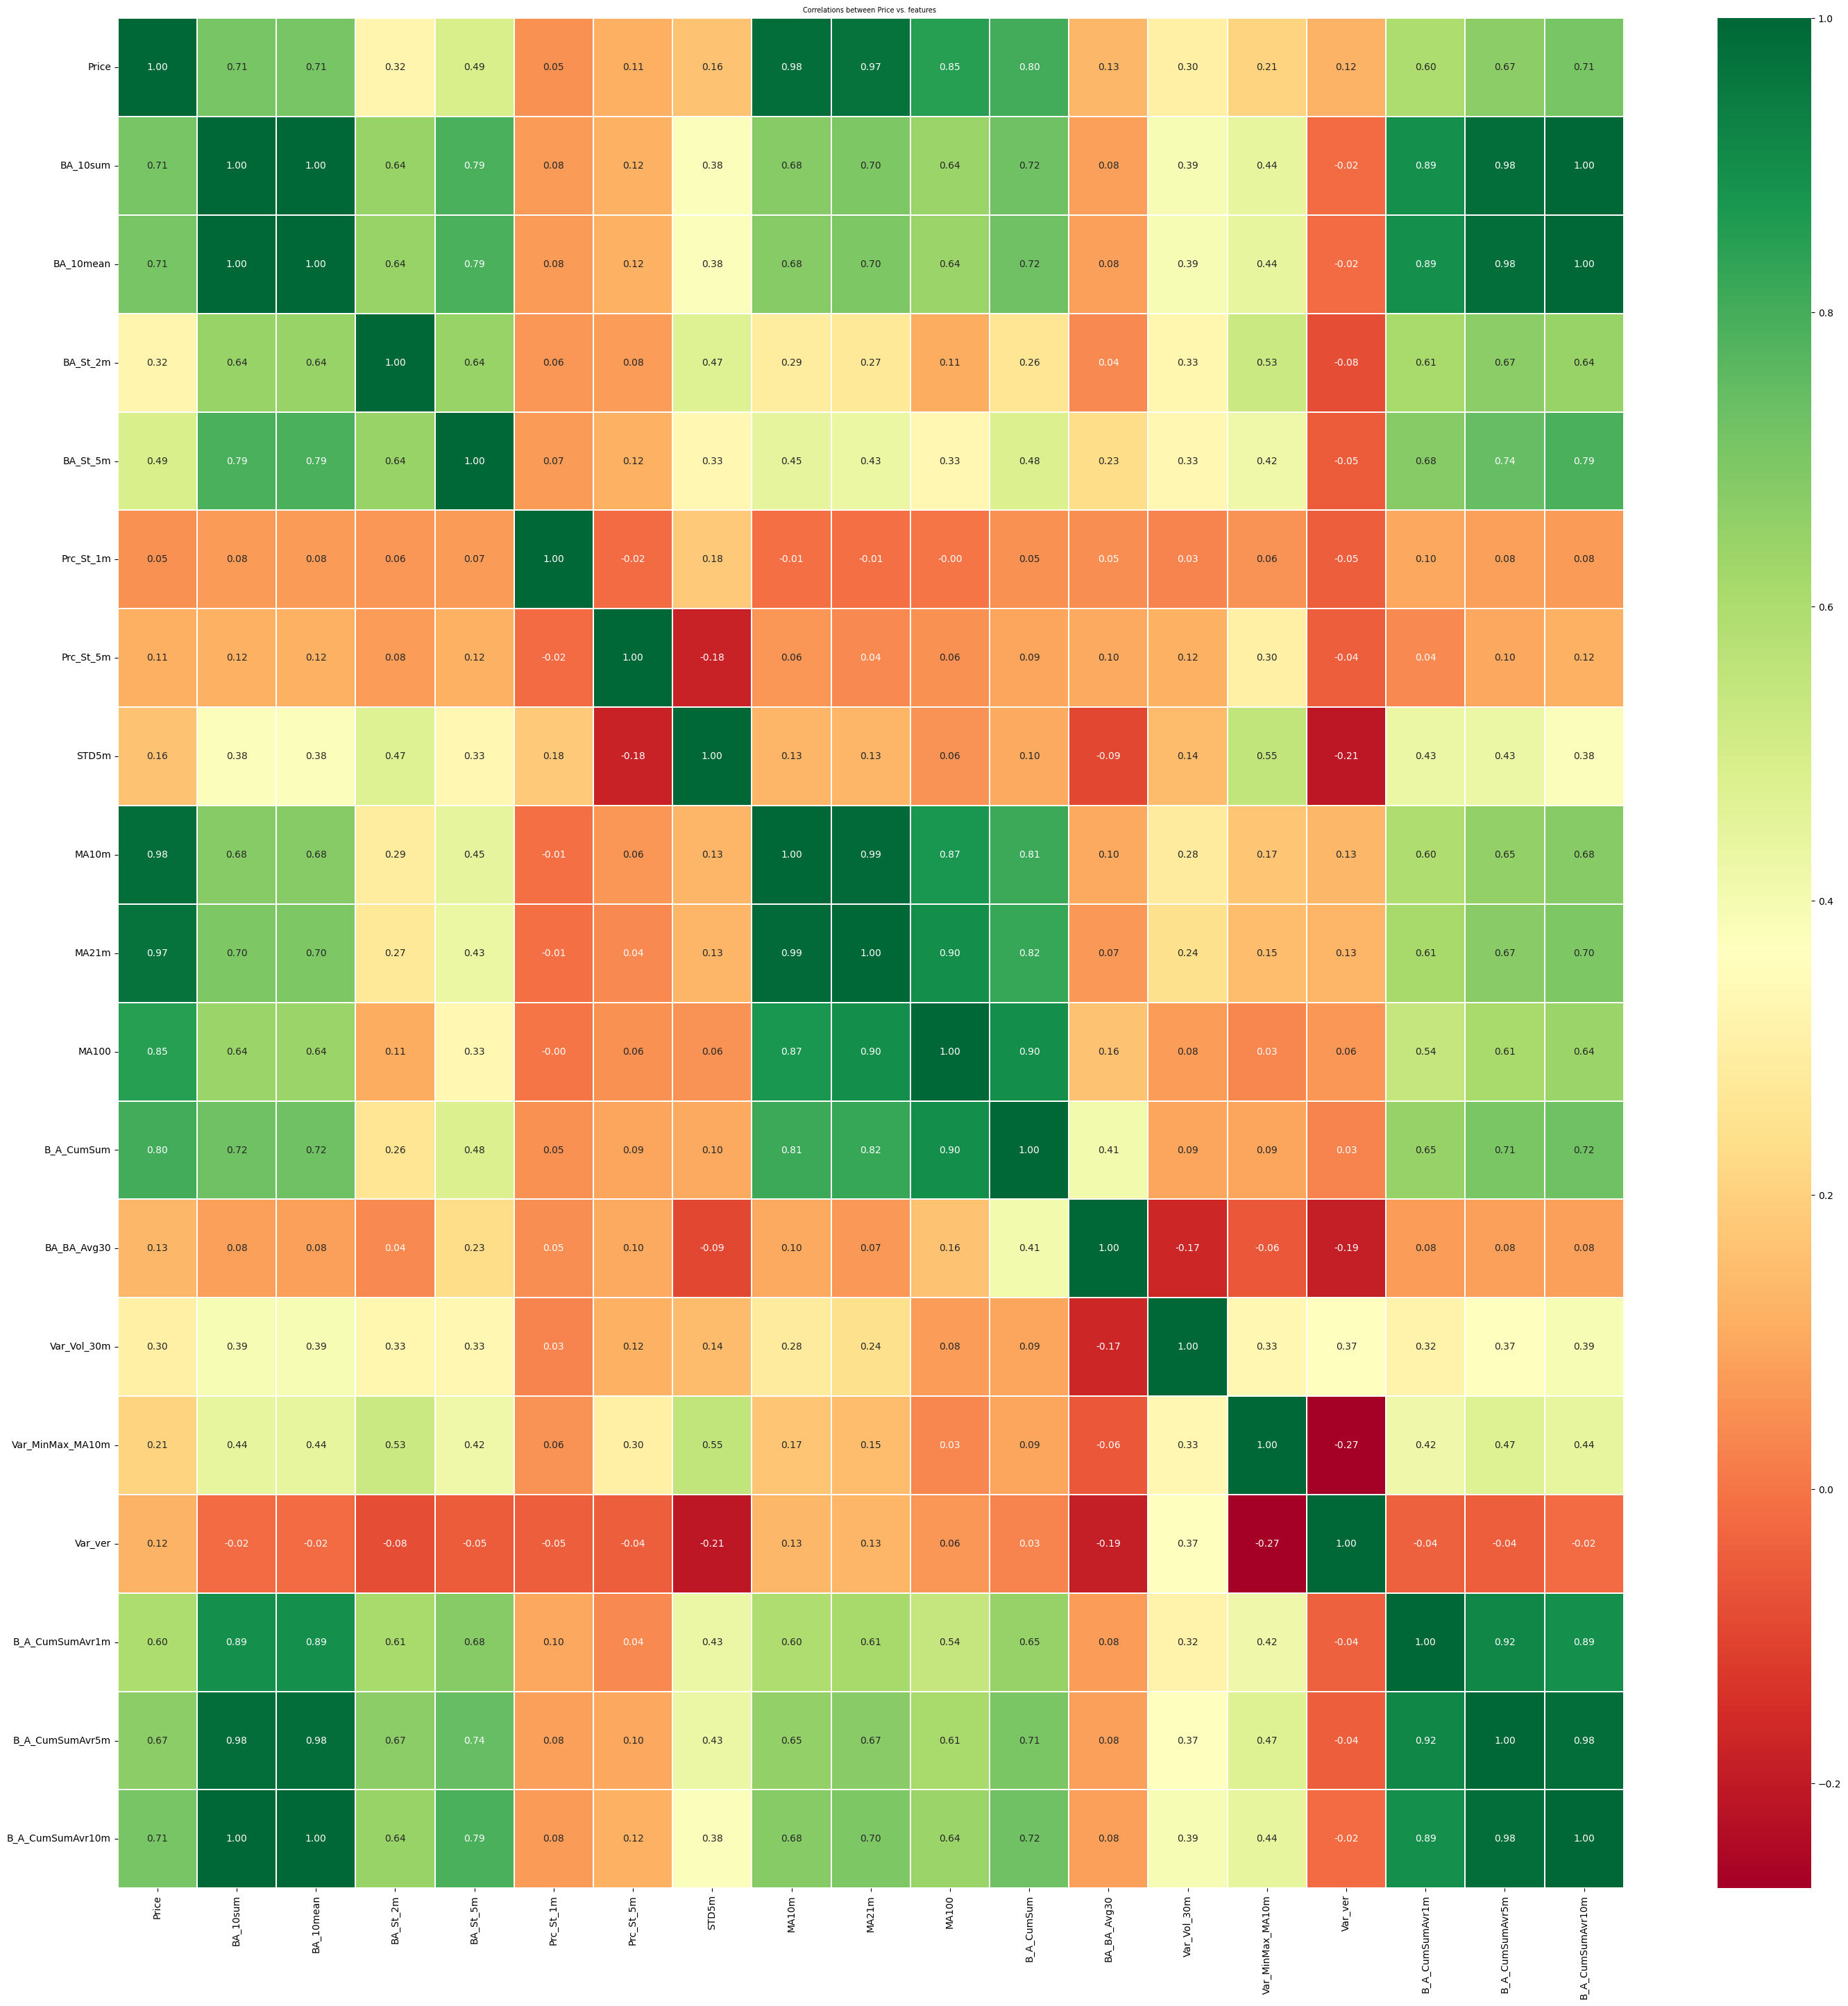

In [66]:
#Seaborn heatmap of correlations in es data

plt.subplots(figsize=(35,35))

#matrix = np.tril(es.corr())
#sns.heatmap(es.corr(), linewidths=.1, annot=True, cmap='coolwarm', center=0, mask=matrix);
sns.heatmap(fff[ar].corr(), linewidths=.2, annot=True, cmap='RdYlGn',  fmt='.2f');
plt.title('Correlations between Price vs. features ', fontsize=7)

In [70]:
es__scale2 = fff[ar]
es__scale2.columns
es__scale2.shape

(40912, 19)

In [80]:
# Create a new dataframe, `es__scale` from `fff` 
es__scale2 = fff[ar]
# Save the labels (using the index attribute of `es1`) into the variable 'es_index'
es_index2 = es__scale2.index
# # Save the column names (using the `columns` attribute) of `es1` into the variable 'es_columns'
es_columns2 = es__scale2.columns
es__scale2 = es__scale2.fillna(0)
es__scale2 = es__scale2[np.isfinite(es__scale2).all(1)]  # to get rid of Infinite values 

In [ ]:
es__scale2

In [83]:
es__scale2 = es__scale2.fillna(0)
es__scale = es__scale2[np.isfinite(es__scale2).all(1)]  # to get rid of Infinite values 

In [ ]:
es_scaled_df2 = pd.DataFrame(es__scale2, columns= es_columns2)
es_scaled_df2.sample(9)

In [85]:
es_pca2 = PCA().fit(es_scaled_df2)

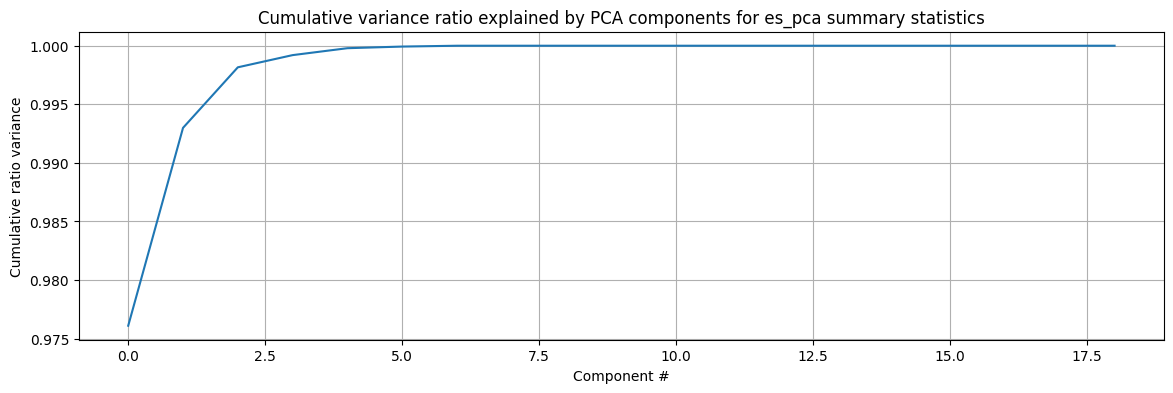

In [86]:
plt.subplots(figsize=(14, 4))
plt.plot(es_pca2.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for es_pca summary statistics')
plt.grid()

In [93]:
# function to create scatterplots of Price against desired columns
def scatterplots(columns, ncol=None, figsize=(50, 50)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Price', data=fff, alpha=0.5)
        ax.set(xlabel=col, ylabel='Price')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [97]:
features = [x for x in fff.columns ]

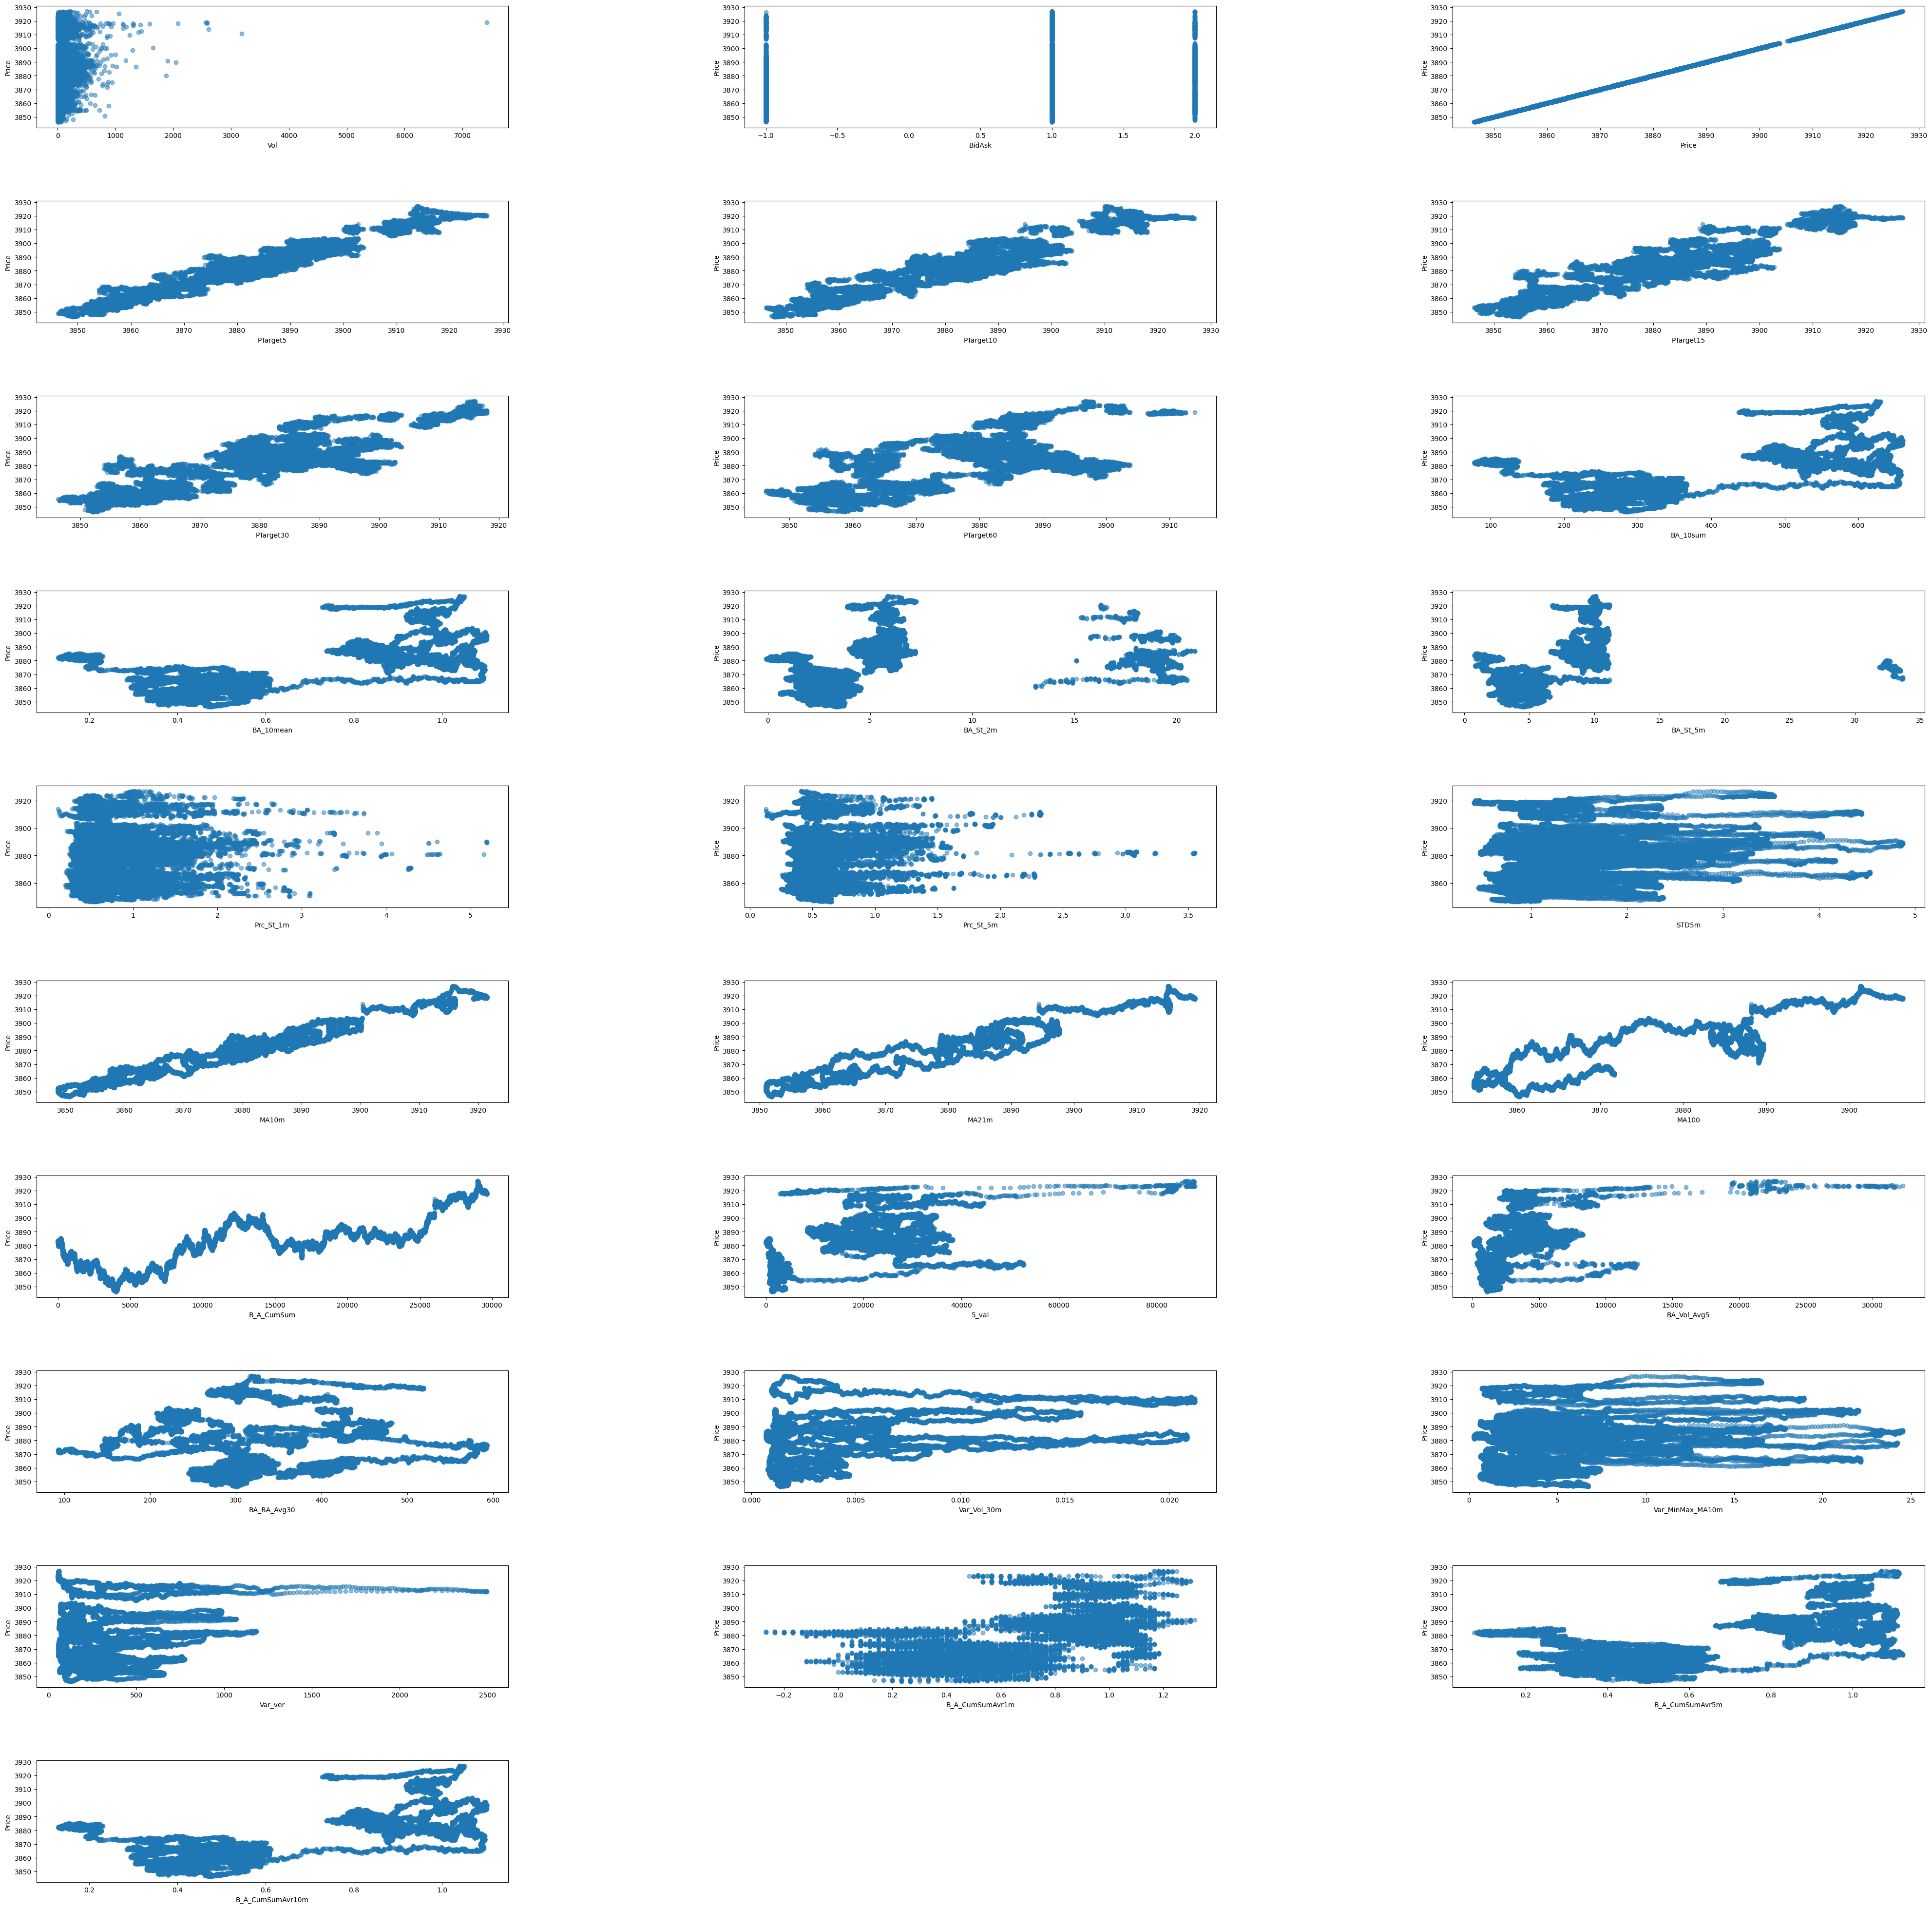

In [98]:
scatterplots(features, ncol=3, figsize=(50, 50)) # scatterplots(features, ncol=5, figsize=(17, 17))

### Modeling a limited time (30 min) uprun with a simple set 

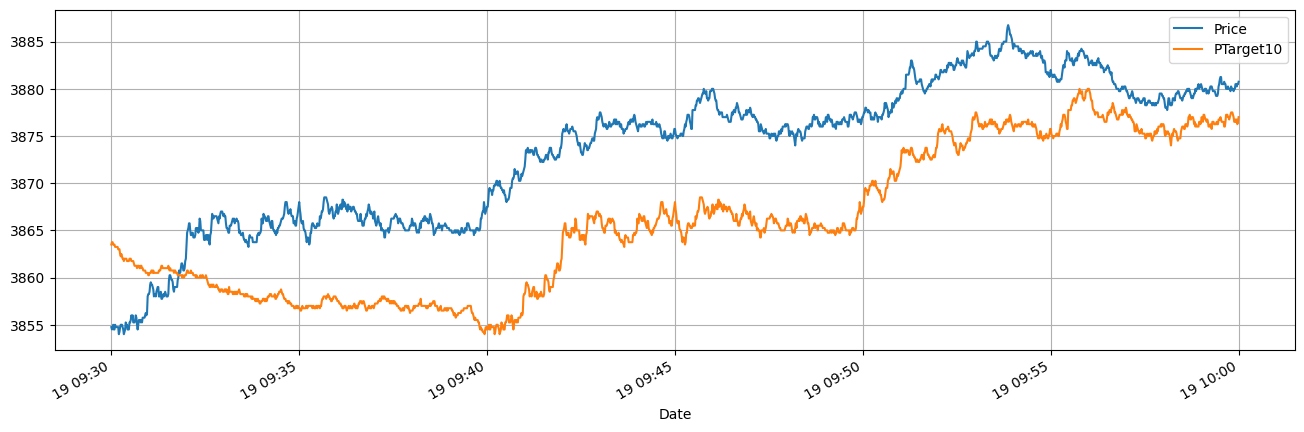

In [55]:
uprun = fff['2022-09-19 09:30:00': '2022-09-19 10:00:00'].copy()
uprun.shape  # (1800, 28) session needed until 4:20 at most (reduced size of set) 
uprun.columns
uprun.plot( y=['Price','PTarget10'], figsize=(16,5)) # 10 min into the future shifted  Price
plt.grid()

In [56]:
import seaborn as sns
%matplotlib inline

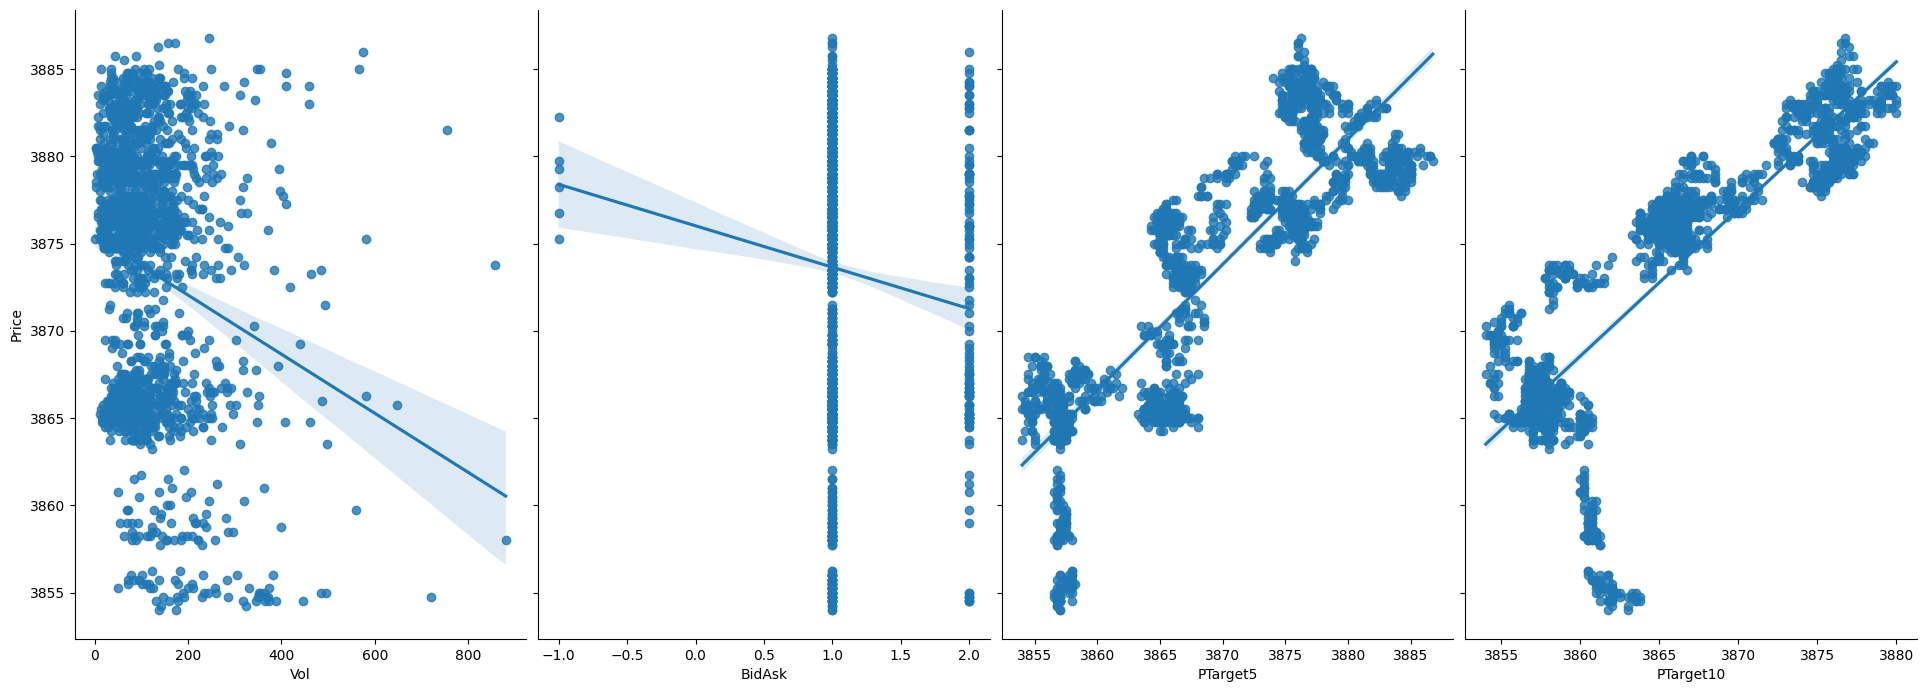

In [58]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(uprun, x_vars=['Vol','BidAsk','PTarget5', 'PTarget10',], y_vars='Price', height=7, aspect=0.7, kind='reg')

- Conclusions:
-  Obviously PriceTarget as a derivative time-shifted of Price is related to Price. 
- The uprun is related to PREPONDERANCE of Ask and AboveAsk 
buying (1,2). 
- Volume has no linear asspociation to Price.

SPLINE function 

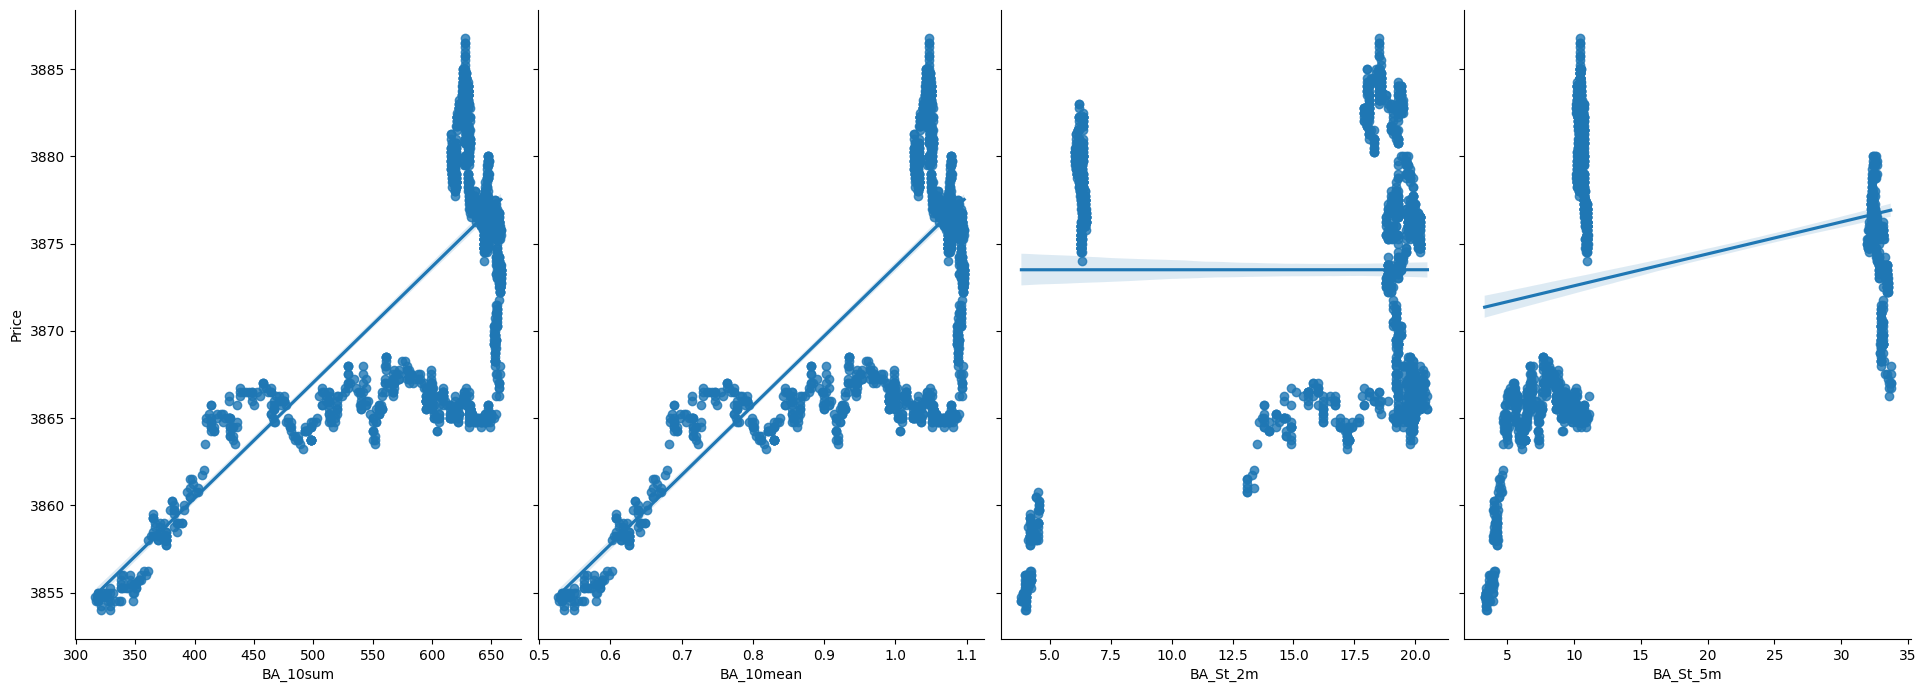

In [59]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(uprun, x_vars=['BA_10sum','BA_10mean','BA_St_2m', 'BA_St_5m',], y_vars='Price', height=7, aspect=0.7, kind='reg')

-  'BA_10sum','BA_10mean' have linear assocuation to Price and are interesting for further review.

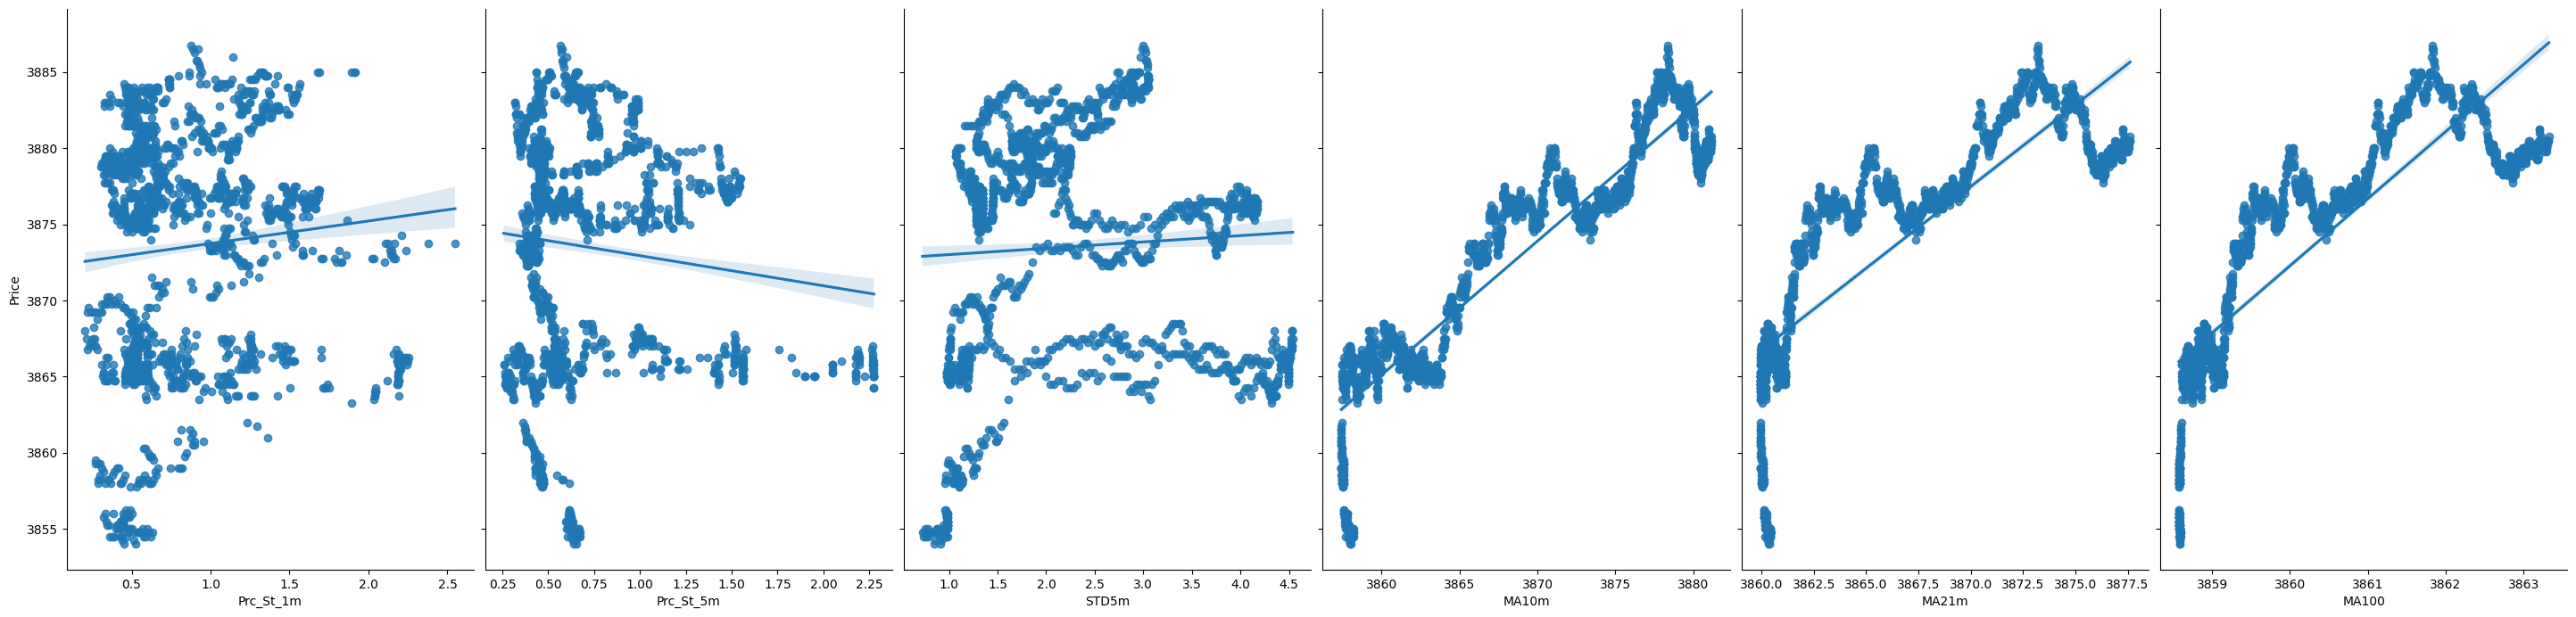

In [62]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(uprun, x_vars=['Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m', 'MA100'], y_vars='Price', height=7, aspect=0.7, kind='reg')

- 'MA10m', 'MA21m', 'MA100' have linear assocuation to Price and are interesting for further review. This is expected because they are MA's of Price. However lagging.

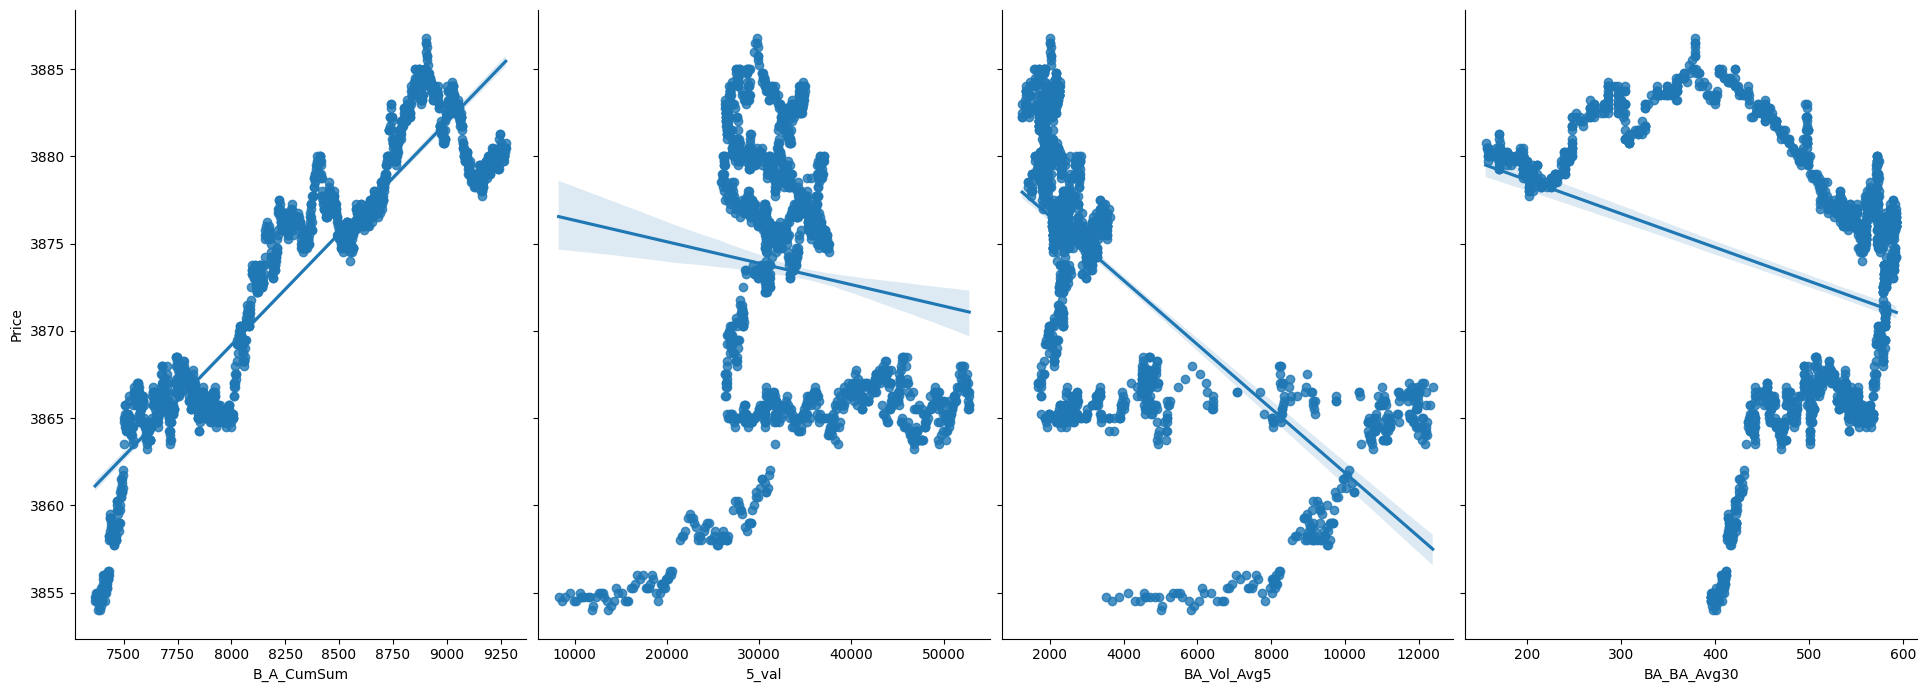

In [63]:
sns.pairplot(uprun, x_vars=['B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30'], y_vars='Price', height=7, aspect=0.7, kind='reg')

'B_A_CumSum' has Intersting positive linear correlation. As the cummulative sum of BidAsk it is expected to be reflected in Price. The '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30' lean towards negative linearity however too noisy to consider for Linear Regression.


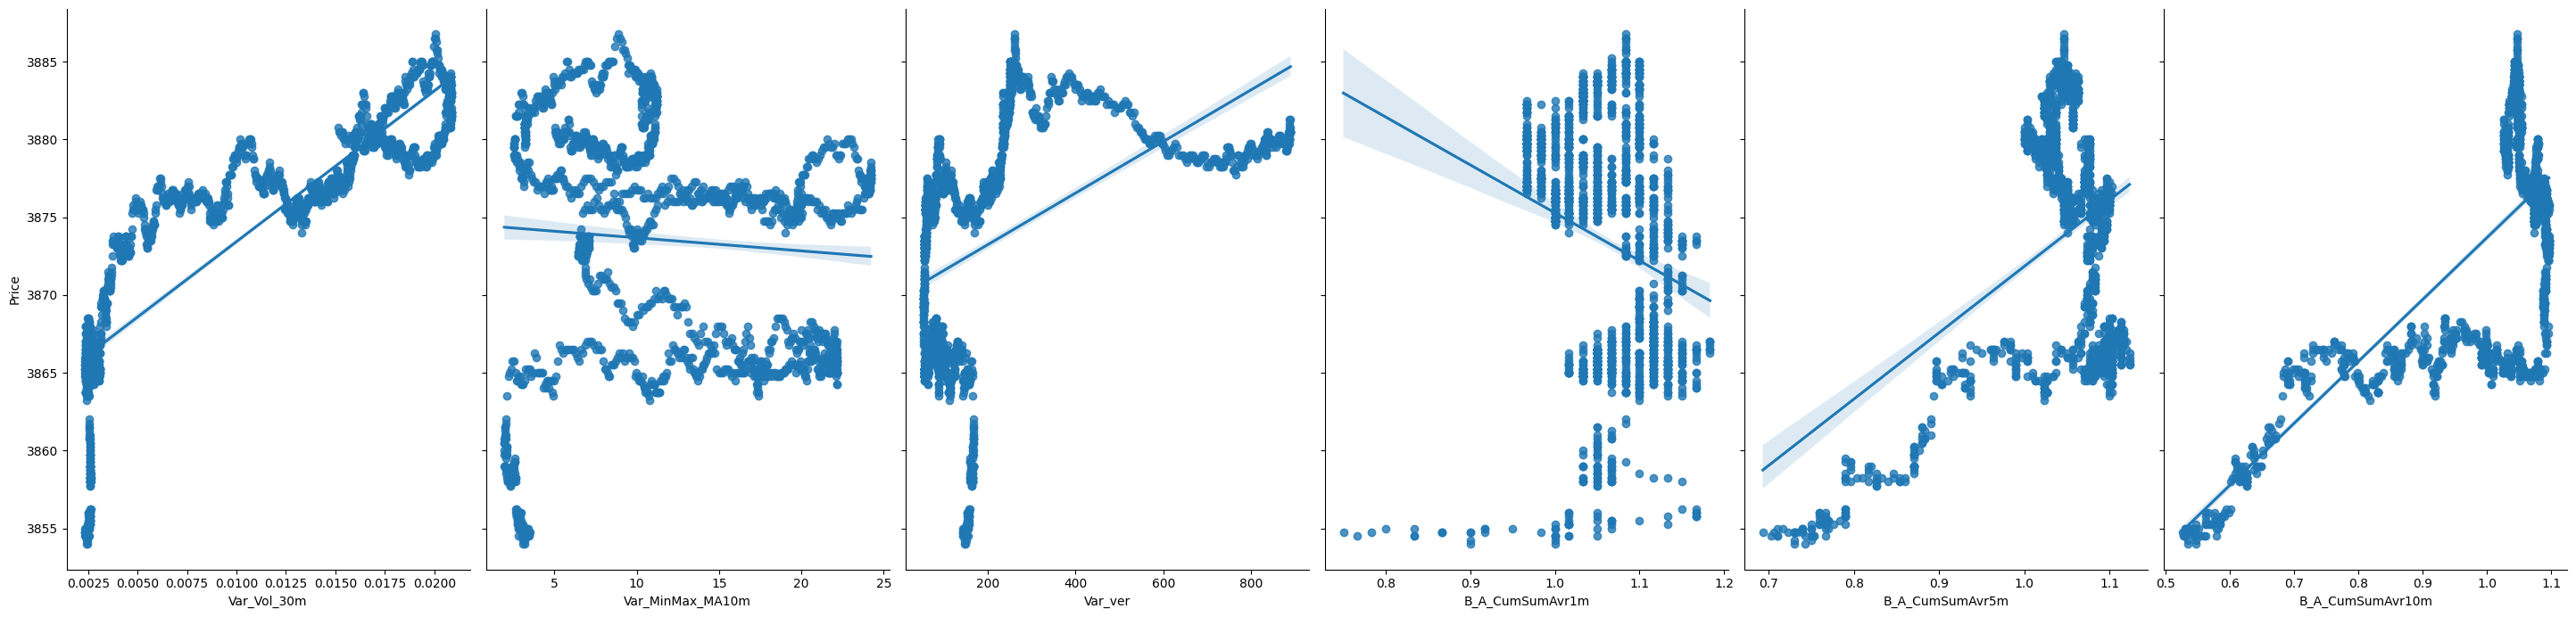

In [64]:
sns.pairplot(uprun, x_vars=['Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'], y_vars='Price', height=7, aspect=0.7, kind='reg')

## Uprun dataset EIA

- 'Var_Vol_30m',  'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m' have worthy of investigation positive correlation to Price.

In [57]:
uprun.columns

Index(['Vol', 'BidAsk', 'Price', 'PTarget5', 'PTarget10', 'PTarget15',
       'PTarget30', 'PTarget60', 'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'],
      dtype='object')

In [99]:
X_features = uprun[['BidAsk','BA_10sum','BA_10sum','BA_10mean','Var_Vol_30m','B_A_CumSumAvr5m', 'B_A_CumSumAvr10m','B_A_CumSum', 'MA10m','MA21m', 'MA100','Price']]  #
y_features = uprun[['PTarget5', 'PTarget10', 'PTarget15']]

In [100]:
X_features.shape

(1800, 12)

In [102]:
X_features.head(3)

BidAsk  BA_10sum  BA_10sum  BA_10mean  Var_Vol_30m  \
Date                                                                      
2022-09-19 09:30:00     2.0     316.0     316.0   0.526667     0.002333   
2022-09-19 09:30:01     2.0     317.0     317.0   0.528333     0.002340   
2022-09-19 09:30:02     2.0     318.0     318.0   0.530000     0.002346   

                     B_A_CumSumAvr5m  B_A_CumSumAvr10m  B_A_CumSum  \
Date                                                                 
2022-09-19 09:30:00         0.693333          0.526667      7367.0   
2022-09-19 09:30:01         0.703333          0.528333      7369.0   
2022-09-19 09:30:02         0.706667          0.530000      7371.0   

                           MA10m        MA21m        MA100    Price  
Date                                                                 
2022-09-19 09:30:00  3858.220833  3860.441667  3858.593667  3854.75  
2022-09-19 09:30:01  3858.205417  3860.435119  3858.593292  3854.50  
2022-09-19 09:30:02  3858.190417  3860.428770  3858.592917  3854.75

In [82]:
y_features.tail()
y_feature5 = y_features['PTarget5']
y_feature5.shape

(1800,)

In [104]:
type(X_features)  # pandas.core.frame.DataFrame
# X_features = X_features.to_numpy()
type(X_features)   #   numpy.ndarray

pandas.core.frame.DataFrame

In [106]:

feature_cols = X_features
feature_cols.shape   #  (1800, 12)
# use the list to select a subset of the original DataFrame
X = feature_cols

# equivalent command to the above this in one line
XBoo = uprun[['BidAsk','BA_10sum','BA_10sum','BA_10mean','Var_Vol_30m','B_A_CumSumAvr5m', 'B_A_CumSumAvr10m','B_A_CumSum', 'MA10m','MA21m', 'MA100','Price']]
XBoo.head()
# print the first 5 rows
X.head()

BidAsk  BA_10sum  BA_10sum  BA_10mean  Var_Vol_30m  \
Date                                                                      
2022-09-19 09:30:00     2.0     316.0     316.0   0.526667     0.002333   
2022-09-19 09:30:01     2.0     317.0     317.0   0.528333     0.002340   
2022-09-19 09:30:02     2.0     318.0     318.0   0.530000     0.002346   
2022-09-19 09:30:03     2.0     319.0     319.0   0.531667     0.002352   
2022-09-19 09:30:04     1.0     319.0     319.0   0.531667     0.002358   

                     B_A_CumSumAvr5m  B_A_CumSumAvr10m  B_A_CumSum  \
Date                                                                 
2022-09-19 09:30:00         0.693333          0.526667      7367.0   
2022-09-19 09:30:01         0.703333          0.528333      7369.0   
2022-09-19 09:30:02         0.706667          0.530000      7371.0   
2022-09-19 09:30:03         0.710000          0.531667      7373.0   
2022-09-19 09:30:04         0.710000          0.531667      7374.0   

                           MA10m        MA21m        MA100    Price  
Date                                                                 
2022-09-19 09:30:00  3858.220833  3860.441667  3858.593667  3854.75  
2022-09-19 09:30:01  3858.205417  3860.435119  3858.593292  3854.50  
2022-09-19 09:30:02  3858.190417  3860.428770  3858.592917  3854.75  
2022-09-19 09:30:03  3858.176250  3860.422421  3858.592583  3855.00  
2022-09-19 09:30:04  3858.161250  3860.415675  3858.592125  3854.50

In [109]:
print(type(X))
print(X.shape)
print(type(XBoo))
print(XBoo.shape)

<class 'pandas.core.frame.DataFrame'>
(1800, 12)
<class 'pandas.core.frame.DataFrame'>
(1800, 12)


In [110]:
y = y_feature5
y.head()

Date
2022-09-19 09:30:00    3856.75
2022-09-19 09:30:01    3856.75
2022-09-19 09:30:02    3856.50
2022-09-19 09:30:03    3856.50
2022-09-19 09:30:04    3856.75
Name: PTarget5, dtype: float64

In [111]:
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(1800,)


In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [113]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1350, 12)
(1350,)
(450, 12)
(450,)


In [114]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression()

In [115]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

63066.04726556729
[ 1.26804779e-01  1.20837383e-02  1.20837412e-02  2.01395524e-05
  5.03365106e+02 -4.11329071e+01  2.01395757e-05  7.21155445e-02
 -2.73928574e+00  1.74737786e+00 -1.40186585e+01 -4.68518027e-01]


# Question: What the coefficients mean?  What the intercept_ mean? 

In [116]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('BidAsk', 0.12680477868120169),
 ('BA_10sum', 0.012083738260541852),
 ('BA_10sum', 0.01208374122440888),
 ('BA_10mean', 2.0139552432535177e-05),
 ('Var_Vol_30m', 503.3651055225971),
 ('B_A_CumSumAvr5m', -41.132907065968574),
 ('B_A_CumSumAvr10m', 2.013957570600956e-05),
 ('B_A_CumSum', 0.0721155444569679),
 ('MA10m', -2.7392857399906587),
 ('MA21m', 1.7473778634417039),
 ('MA100', -14.018658496451472),
 ('Price', -0.468518026652706)]

## Making Predictions

In [121]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)
y_pred.shape  #  (450,)

(450,)

In [123]:
y.shape

(1800,)

In [124]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

1.2119706741906864


In [125]:
# calculate MSE using scikit-learn
print(metrics.mean_squared_error(y_test, y_pred))

2.3868904457504887


In [127]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

1.5449564543217678


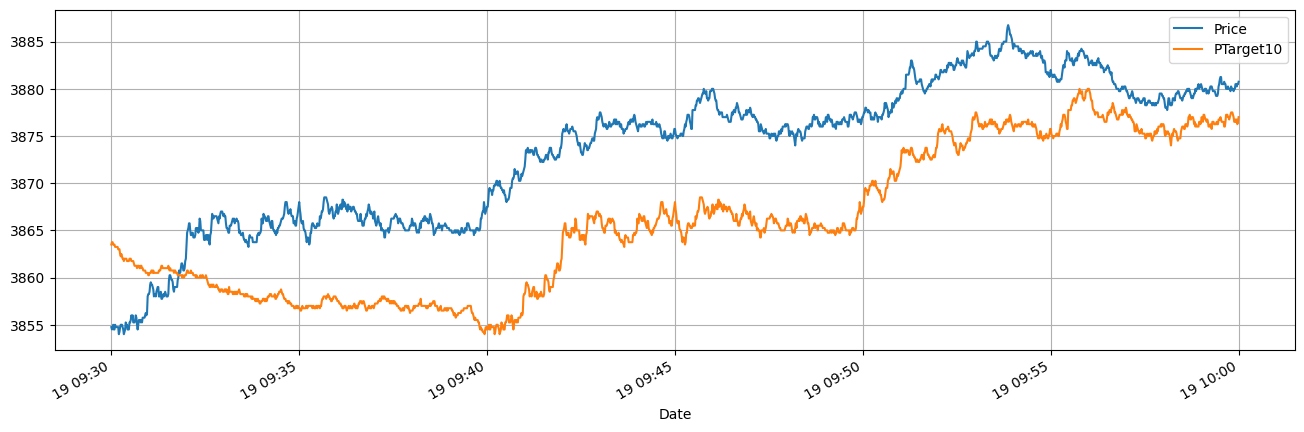

In [142]:
uprun.plot( y=['Price','PTarget10'], figsize=(16,5)) # 10 min into the future shifted  Price
plt.grid()

In [161]:
uprun.columns

Index(['Vol', 'BidAsk', 'Price', 'PTarget5', 'PTarget10', 'PTarget15',
       'PTarget30', 'PTarget60', 'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'],
      dtype='object')

In [163]:
fff.columns

Index(['Vol', 'BidAsk', 'Price', 'PTarget5', 'PTarget10', 'PTarget15',
       'PTarget30', 'PTarget60', 'BA_10sum', 'BA_10mean', 'BA_St_2m',
       'BA_St_5m', 'Prc_St_1m', 'Prc_St_5m', 'STD5m', 'MA10m', 'MA21m',
       'MA100', 'B_A_CumSum', '5_val', 'BA_Vol_Avg5', 'BA_BA_Avg30',
       'Var_Vol_30m', 'Var_MinMax_MA10m', 'Var_ver', 'B_A_CumSumAvr1m',
       'B_A_CumSumAvr5m', 'B_A_CumSumAvr10m'],
      dtype='object')

In [165]:
es.columns

Index(['Vol', 'BidAsk', 'Price', 'Date'], dtype='object')

In [ ]:
uprun['Date'] = es['2022-09-19 09:30:00': '2022-09-19 10:00:00']['Date'].copy()

In [ ]:
sns.pairplot(uprun, x_vars= uprun.index , y_vars=[y_test, y_pred], height=7, aspect=0.7, kind='reg')

<AxesSubplot: >

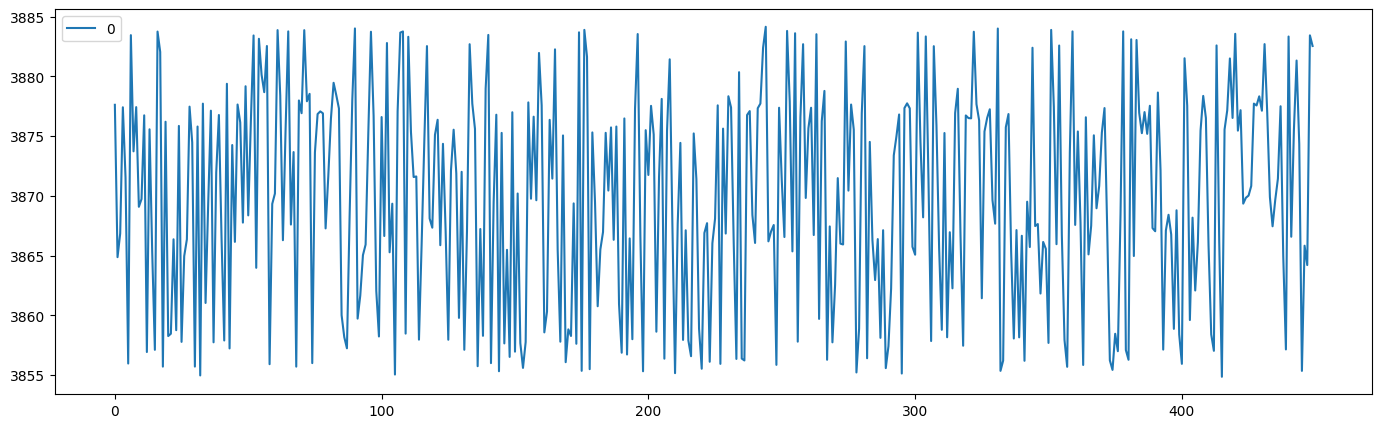

In [141]:
y_predPlot = pd.DataFrame(y_pred)
y_predPlot.plot(figsize=(17,5))

<AxesSubplot: xlabel='Date'>

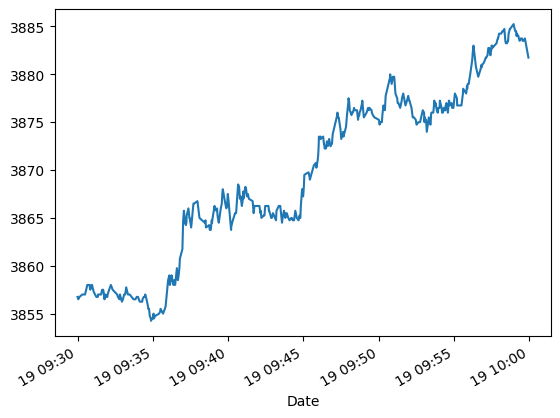

In [135]:
y_test.plot()

In [131]:
forPlot = uprun.copy()
forPlot.shape
y_pred.shape # (450,)
y_test.shape  # (450,)

(450,)

Notes and TBDone: Well, this was expected , since linear Regression defines a linear line and ascilates around the Price. The y_pred osilates between 3855 and 3885, which is the entire range Price has fluctuated. It's not clear if the y_pred X axis is equivalent to Time, and remains to define a clear transfer of TimeSeries axis X 

### Second attempt of Linear Regression without splitting and preserving the timeline.

In [150]:
from sklearn.model_selection import train_test_split
X_all, y_all = train_test_split( X, random_state= 1)


In [151]:
X_all.shape   #  (1350, 12)
y_all.shape   #  (450, 12)


(450, 12)

<AxesSubplot: xlabel='Date'>

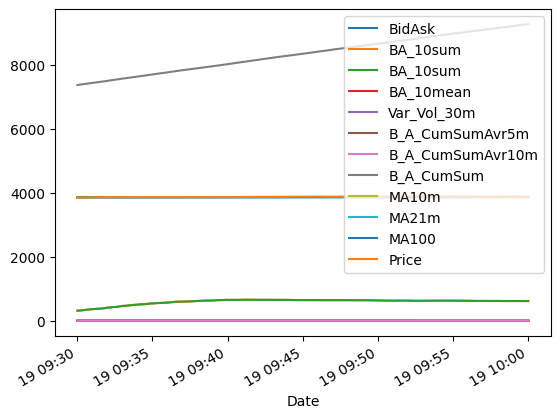

In [153]:
X_all.plot()

<AxesSubplot: xlabel='Date'>

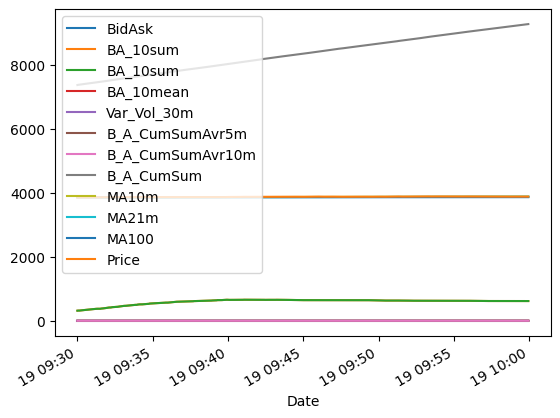

In [152]:
y_all.plot()

Time may be preserved ...